In [1]:
import os
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import tkinter as tk
from PIL import Image
from tkinter import filedialog
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
# ============================
# 1. PATH & PARAMETER
# ============================
new_data_dir = r"D:\Penelitian\Dataset Tahap 2"
preprocessed_new_dir = r"D:\Penelitian\Preprocessed_TAHAP2"
split_new_dir = r"D:\Penelitian\Split_TAHAP2"

batch_size = 16
target_size = (224, 224)
epochs = 100
num_classes = 4

In [3]:
# ============================
# PREPROCESSING
# ============================
def preprocess_and_save(source_dir, dest_dir, target_size=(224, 224)):
    if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
        class_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

        if not class_folders:
            print("❌ Folder dataset tidak memiliki subfolder kelas. Pastikan struktur dataset benar.")
            return

        for class_name in class_folders:
            src_path = os.path.join(source_dir, class_name)
            dst_path = os.path.join(dest_dir, class_name)
            os.makedirs(dst_path, exist_ok=True)

            for img_name in os.listdir(src_path):
                img_path = os.path.join(src_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(target_size)

                    img_array = np.asarray(img).astype(np.float32) / 255.0
                    save_img = Image.fromarray((img_array * 255).astype(np.uint8))

                    save_path = os.path.join(dst_path, img_name)
                    save_img.save(save_path)
                except Exception as e:
                    print(f"Gagal memproses {img_path}: {e}")

        print(f"✅ Preprocessing selesai dan disimpan di: {dest_dir}")
    else:
        print(f"✅ Preprocessed data sudah ada di: {dest_dir}")

In [4]:
# ============================
# SPLIT DATA
# ============================
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    train_dir = os.path.join(dest_dir, 'train')
    if not os.path.exists(train_dir) or not os.listdir(train_dir):
        class_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

        for class_name in class_folders:
            src_class = os.path.join(source_dir, class_name)
            images = [f for f in os.listdir(src_class) if os.path.isfile(os.path.join(src_class, f))]
            random.shuffle(images)
            total = len(images)
            train_end = int(train_ratio * total)
            val_end = train_end + int(val_ratio * total)

            for i, img_name in enumerate(images):
                subset = "train" if i < train_end else "val" if i < val_end else "test"
                dst_path = os.path.join(dest_dir, subset, class_name)
                os.makedirs(dst_path, exist_ok=True)
                shutil.copy(os.path.join(src_class, img_name), os.path.join(dst_path, img_name))

        print(f"✅ Data telah di-split dan disimpan di: {dest_dir}")
    else:
        print(f"✅ Data sudah ada di folder {dest_dir}, split tidak dilakukan.")

# ============================
# JALANKAN
# ============================
preprocess_and_save(new_data_dir, preprocessed_new_dir, target_size=target_size)
split_data(preprocessed_new_dir, split_new_dir)

✅ Preprocessed data sudah ada di: D:\Penelitian\Preprocessed_TAHAP2
✅ Data sudah ada di folder D:\Penelitian\Split_TAHAP2, split tidak dilakukan.


In [8]:
# ============================
# 4. DATA GENERATOR TAHAP 2
# ============================
train_gen_tahap2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)
val_test_gen_tahap2 = ImageDataGenerator()

train_generator_tahap2 = train_gen_tahap2.flow_from_directory(
    os.path.join(split_new_dir, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)
val_generator_tahap2 = val_test_gen_tahap2.flow_from_directory(
    os.path.join(split_new_dir, "val"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)
test_generator_tahap2 = val_test_gen_tahap2.flow_from_directory(
    os.path.join(split_new_dir, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 570 images belonging to 4 classes.
Found 119 images belonging to 4 classes.
Found 126 images belonging to 4 classes.


In [47]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEBAGIAN LAYER (60%)
# ============================
total_layers = len(best_model.layers)
for i, layer in enumerate(best_model.layers):
    if i < int(total_layers * 0.4):
        layer.trainable = False
    else:
        layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER (ReLU SAJA)
# ============================
x = best_model.layers[-5].output
x = GlobalAveragePooling2D(name='gap_new')(x)

x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax')(x)

fine_tune = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL
# ============================
fine_tune.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)
fine_tune.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,727,364 (82.88 MB)

 Trainable params: 20,651,076 (78.78 MB)

 Non-trainable params: 1,076,288 (4.11 MB)

In [48]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_2_ke2.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

In [49]:
history_1 = fine_tune.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.2740 - loss: 0.9592
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to Model_Terbaik_Tahap_2_ke2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.2742 - loss: 0.9587 - val_accuracy: 0.2500 - val_loss: 1.4706 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.3558 - loss: 0.9194
Epoch 2: val_accuracy improved from 0.25000 to 0.47500, saving model to Model_Terbaik_Tahap_2_ke2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3564 - loss: 0.9192 - val_accuracy: 0.4750 - val_loss: 0.9297 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.3502 - loss: 0.8925
Epoch 3: val_accuracy improved from 0.47500 to 0.51667, saving model to Model_Terbaik_Tahap_2_ke2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3509 - loss: 0.8924 - val_accuracy: 0.5167 - val_loss: 0.8948 - learning_rate: 1.0000e-04
E

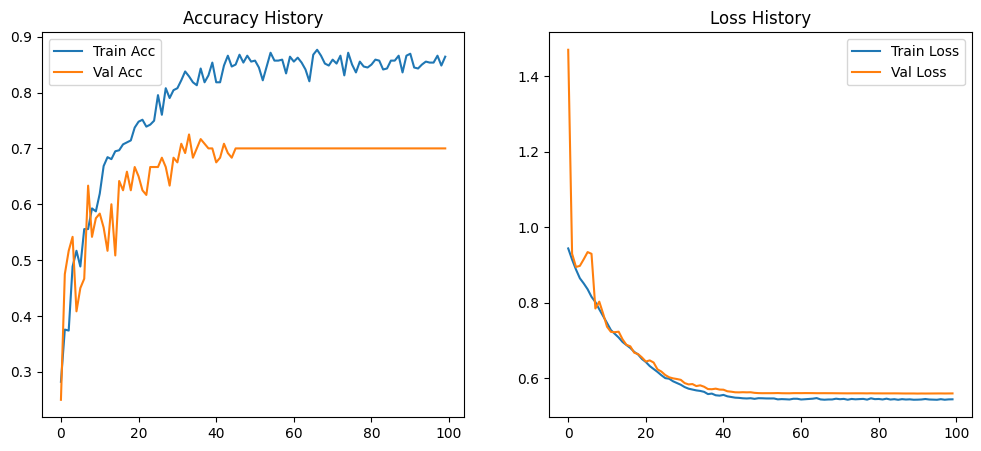

In [50]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Acc')
plt.plot(history_1.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.73      0.71      0.72        31
  Kaukasoid-Indic       0.71      0.65      0.68        31
Malayan_Mongoloid       0.61      0.69      0.65        32
       Melanesoid       0.90      0.90      0.90        31

         accuracy                           0.74       125
        macro avg       0.74      0.74      0.74       125
     weighted avg       0.74      0.74      0.74       125



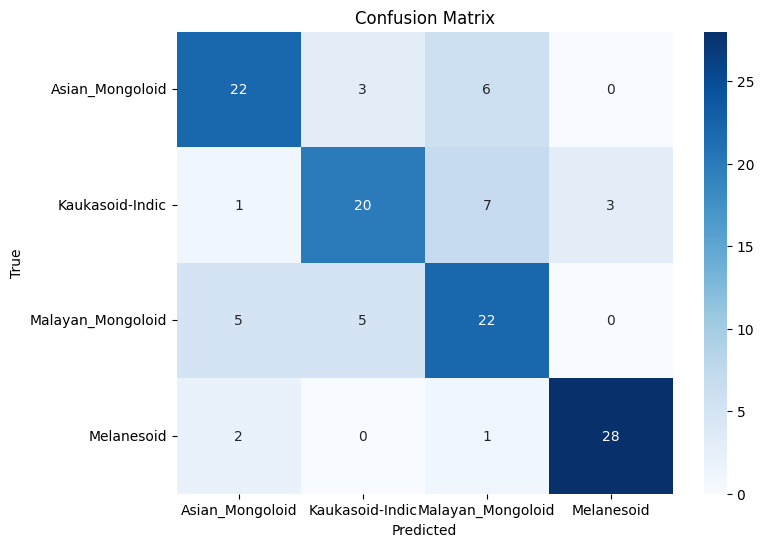

In [51]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.76      0.71      0.73        31
  Kaukasoid-Indic       0.65      0.71      0.68        31
Malayan_Mongoloid       0.74      0.62      0.68        32
       Melanesoid       0.83      0.94      0.88        31

         accuracy                           0.74       125
        macro avg       0.74      0.74      0.74       125
     weighted avg       0.74      0.74      0.74       125



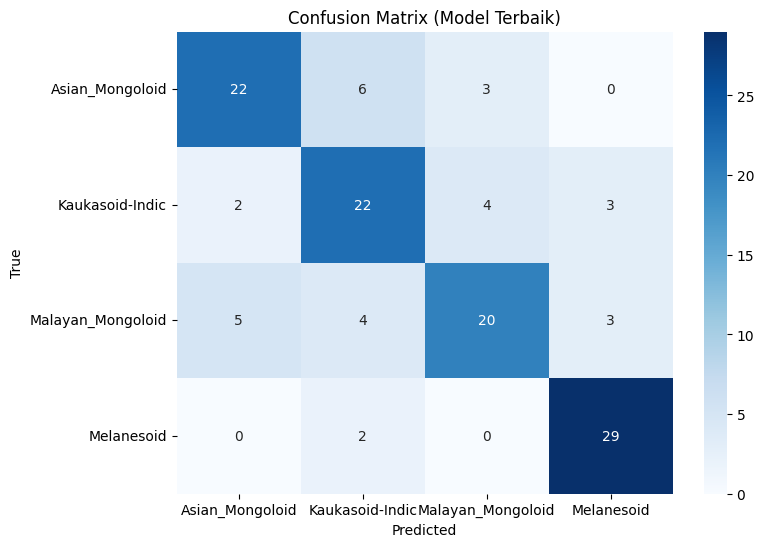

In [52]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_2_ke2.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


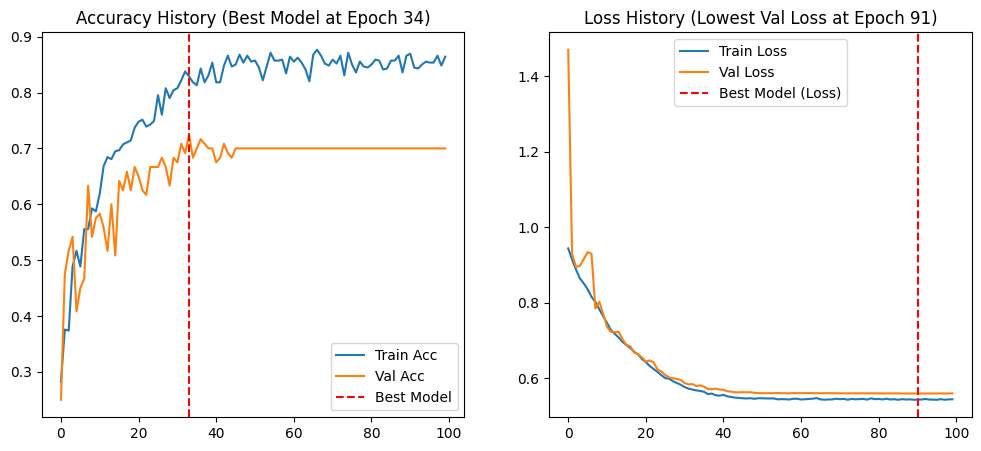

In [54]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Acc')
plt.plot(history_1.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history_1.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history_1.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history_1.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history_1.history['val_loss']) + 1))

plt.show()


## RMSprop + ReLU

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEBAGIAN LAYER (60%)
# ============================
total_layers = len(best_model.layers)
for i, layer in enumerate(best_model.layers):
    if i < int(total_layers * 0.4):
        layer.trainable = False
    else:
        layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER (ReLU)
# ============================
x = best_model.layers[-5].output
x = GlobalAveragePooling2D(name='gap_new')(x)

x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax')(x)

fine_tune_percobaan = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL DENGAN RMSprop
# ============================
fine_tune_percobaan.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)

fine_tune_percobaan.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,727,364 (82.88 MB)

 Trainable params: 20,651,076 (78.78 MB)

 Non-trainable params: 1,076,288 (4.11 MB)

In [11]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_2_ke2_percobaan.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

In [8]:
history_1_percobaan = fine_tune_percobaan.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2727 - loss: 0.9508
Epoch 1: val_accuracy improved from -inf to 0.47500, saving model to Model_Terbaik_Tahap_2_ke2_percobaan.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.2736 - loss: 0.9505 - val_accuracy: 0.4750 - val_loss: 0.9031 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4152 - loss: 0.9139
Epoch 2: val_accuracy did not improve from 0.47500
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4157 - loss: 0.9137 - val_accuracy: 0.4667 - val_loss: 0.9443 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4909 - loss: 0.8904
Epoch 3: val_accuracy improved from 0.47500 to 0.55000, saving model to Model_Terbaik_Tahap_2_ke2_percobaan.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4911 - loss: 0.8902 - val_accuracy: 0.5500 - val_loss: 0.8772 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1

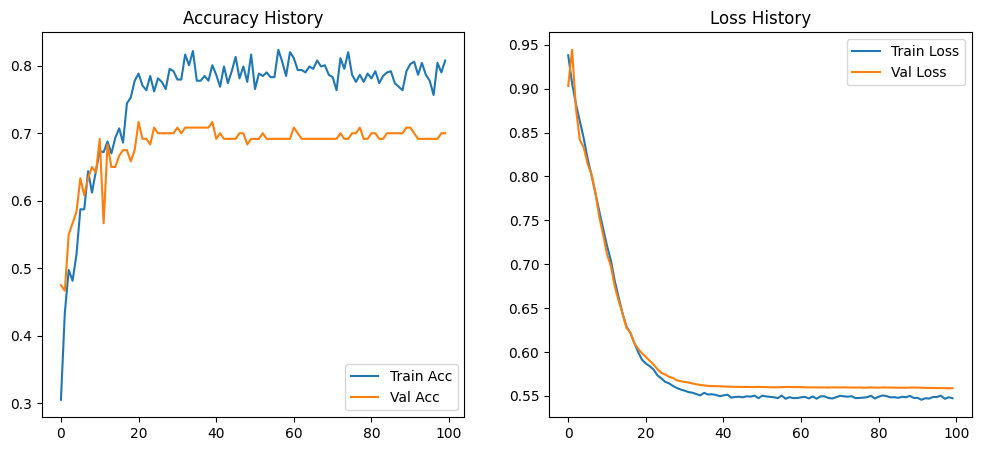

In [12]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_1_percobaan.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_1_percobaan.history['loss'], label='Train Loss')
plt.plot(history_1_percobaan.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

In [17]:
fine_tune_percobaan.save("model_epoch terakhir_tahap 2_ke2_percobaan.keras")

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_2_ke2_percobaan.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()

## TERBAIK EVALUASI MODEL

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.83      0.94      0.88        31
  Kaukasoid-Indic       0.93      0.87      0.90        31
Malayan_Mongoloid       0.85      0.72      0.78        32
       Melanesoid       0.89      0.97      0.93        32

         accuracy                           0.87       126
        macro avg       0.87      0.87      0.87       126
     weighted avg       0.87      0.87      0.87       126



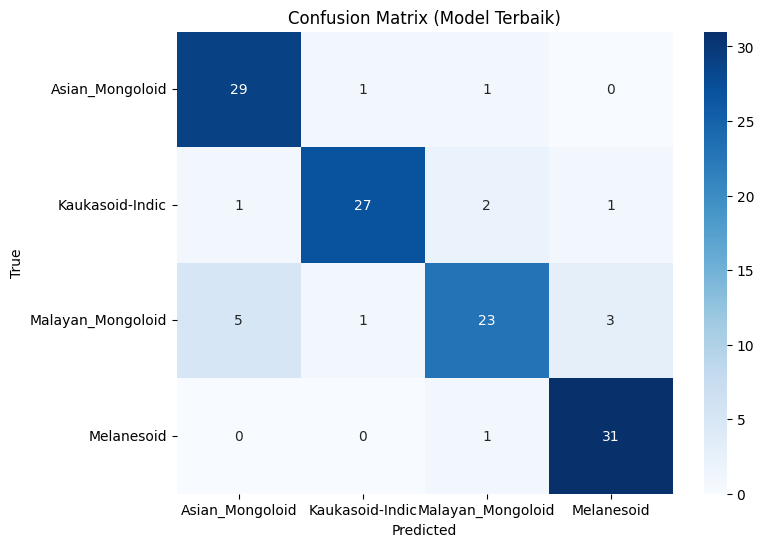

In [46]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\model_epoch terakhir_tahap 2_ke2_percobaan.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()

## UJI DATA TUNGGAL

In [53]:
# ============================
# Direktori Data Tunggal
# ============================
data_tunggal_dir = r"D:\Penelitian\Data Uji Tunggal"
test_tunggal = r"D:\Penelitian\Split_TAHAP2\test_tunggal"
target_size_tunggal = (224, 224)

# ============================
# Fungsi Preprocessing (tidak diubah logika dasarnya)
# ============================
def preprocess_and_save_tunggal(source_dir, dest_dir, target_size=(224, 224)):
    if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
        class_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

        if not class_folders:
            print("❌ Folder dataset tidak memiliki subfolder kelas. Pastikan struktur dataset benar.")
            return

        for class_name in class_folders:
            src_path = os.path.join(source_dir, class_name)
            dst_path = os.path.join(dest_dir, class_name)
            os.makedirs(dst_path, exist_ok=True)

            for img_name in os.listdir(src_path):
                img_path = os.path.join(src_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(target_size)

                    img_array = np.asarray(img).astype(np.float32) / 255.0
                    save_img = Image.fromarray((img_array * 255).astype(np.uint8))

                    save_path = os.path.join(dst_path, img_name)
                    save_img.save(save_path)
                except Exception as e:
                    print(f"Gagal memproses {img_path}: {e}")

        print(f"✅ Preprocessing selesai dan disimpan di: {dest_dir}")
    else:
        print(f"✅ Preprocessed data sudah ada di: {dest_dir}")

# ============================
# Jalankan Preprocessing untuk Data Tunggal
# ============================
preprocess_and_save_tunggal(data_tunggal_dir, test_tunggal, target_size=target_size_tunggal)


✅ Preprocessing selesai dan disimpan di: D:\Penelitian\Split_TAHAP2\test_tunggal


In [54]:
tunggal_generator_tahap2 = val_test_gen_tahap2.flow_from_directory(
    os.path.join(split_new_dir, "test_tunggal"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 14 images belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Total BENAR: 8
❌ Total SALAH: 6


C:\Users\rayna\AppData\Local\Temp\ipykernel_42912\3908031125.py:58: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


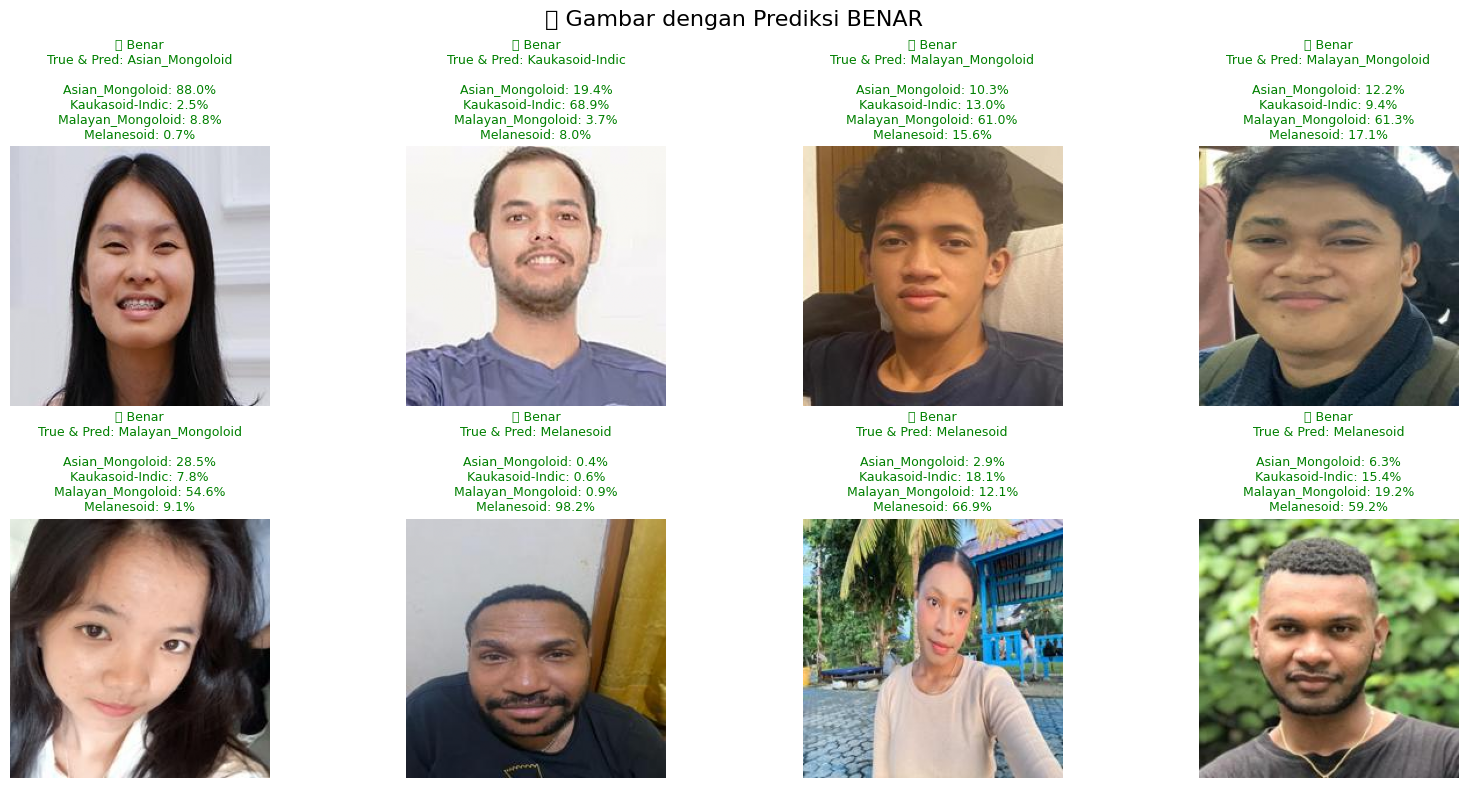

C:\Users\rayna\AppData\Local\Temp\ipykernel_42912\3908031125.py:58: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


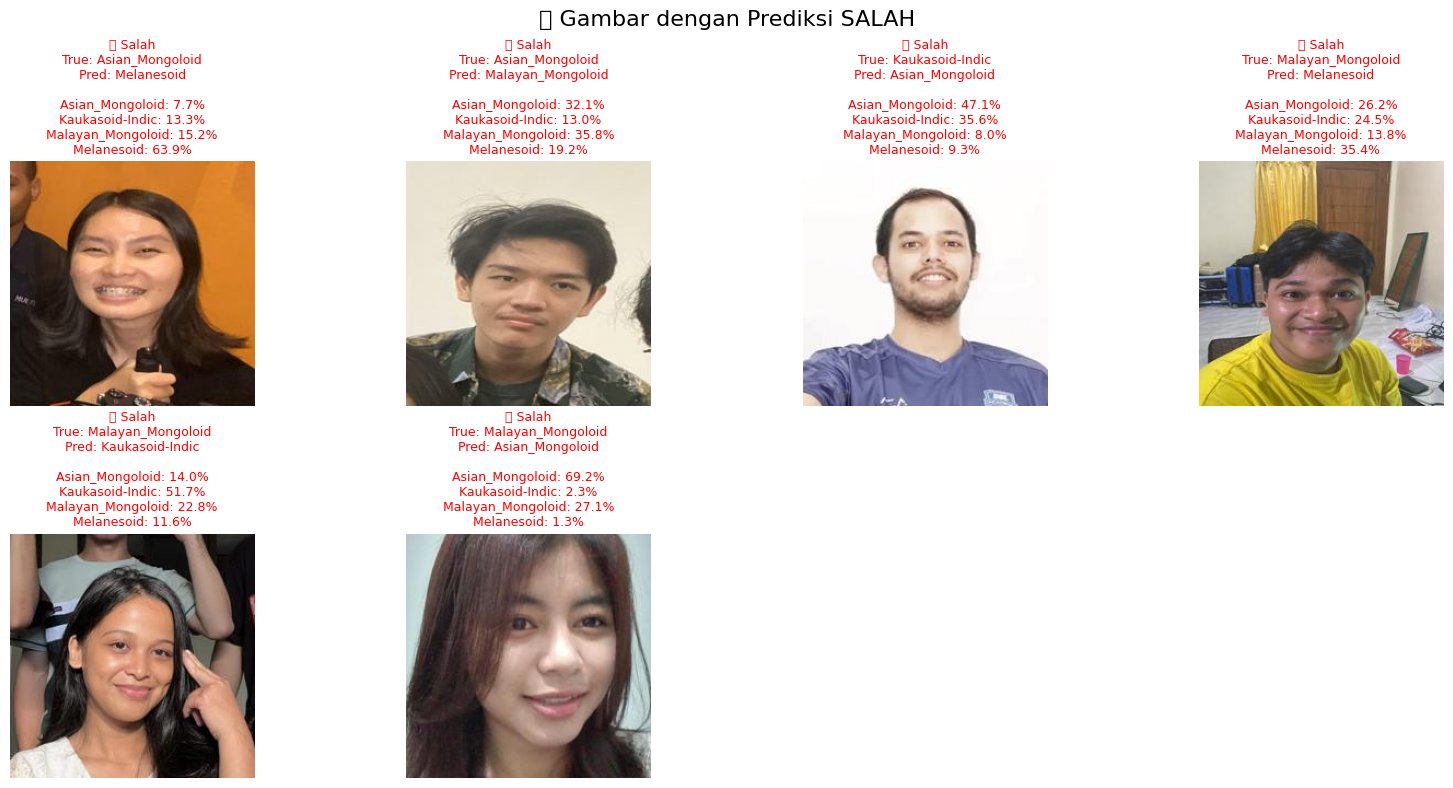

In [55]:
# ====================
# Load Model
# ====================
model_path = r"C:\Users\rayna\Downloads\Penelitian_Alvon\model_epoch terakhir_tahap 2_ke2_percobaan.keras"
model = load_model(model_path, custom_objects={'focal_loss_fixed': focal_loss_tahap2()})

# ====================
# Prediksi
# ====================
pred_probs = model.predict(tunggal_generator_tahap2)
y_pred = np.argmax(pred_probs, axis=1)
y_true = tunggal_generator_tahap2.classes
class_indices = tunggal_generator_tahap2.class_indices
class_labels = list(class_indices.keys())

# ====================
# Ambil file path & gambar
# ====================
filepaths = [tunggal_generator_tahap2.filepaths[i] for i in range(len(tunggal_generator_tahap2.filenames))]
images = []
for path in filepaths:
    img = Image.open(path).resize(target_size).convert("RGB")
    images.append(np.array(img) / 255.0)
images = np.array(images)

# ====================
# Fungsi tampilkan gambar dengan info prediksi & probabilitas
# ====================
def show_prediction_images_with_probs(indices, title, y_true, y_pred, pred_probs, images):
    total = len(indices)
    cols = 4
    rows = (total // cols) + (total % cols > 0)
    plt.figure(figsize=(cols*4, rows*4))

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[idx])
        plt.axis('off')

        true_label = class_labels[y_true[idx]]
        pred_label = class_labels[y_pred[idx]]
        probs = pred_probs[idx]

        prob_text = "\n".join([
            f"{label}: {probs[i]*100:.1f}%" for i, label in enumerate(class_labels)
        ])

        if true_label == pred_label:
            title_color = "green"
            title_text = f"✅ Benar\nTrue & Pred: {true_label}"
        else:
            title_color = "red"
            title_text = f"❌ Salah\nTrue: {true_label}\nPred: {pred_label}"

        plt.title(f"{title_text}\n\n{prob_text}", fontsize=9, color=title_color)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# ====================
# Indeks Benar dan Salah
# ====================
correct_idx = np.where(y_pred == y_true)[0]
incorrect_idx = np.where(y_pred != y_true)[0]

print(f"✅ Total BENAR: {len(correct_idx)}")
print(f"❌ Total SALAH: {len(incorrect_idx)}")

# ====================
# Tampilkan Gambar Benar dan Salah
# ====================
show_prediction_images_with_probs(correct_idx, "✅ Gambar dengan Prediksi BENAR", y_true, y_pred, pred_probs, images)
show_prediction_images_with_probs(incorrect_idx, "❌ Gambar dengan Prediksi SALAH", y_true, y_pred, pred_probs, images)


## DEMO UJI TUNGGAL

# Skenario 2

In [24]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING (DIMODIFIKASI)
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE BEBERAPA LAYER
# ============================
# Bekukan hanya layer awal (misal 50%), agar bisa belajar fitur baru di layer atas
total_layers = len(best_model.layers)
for i, layer in enumerate(best_model.layers):
    if i < total_layers // 2:
        layer.trainable = False
    else:
        layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER
# ============================
# Ambil output dari layer terakhir convolutional
x = best_model.layers[-5].output

# Tambahkan global average pooling untuk meratakan fitur
x = GlobalAveragePooling2D(name='gap_new')(x)

# Tambahkan bottleneck layers baru
x = BatchNormalization(name='batch_norm_new')(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense_512_new')(x)
x = Dropout(0.5, name='dropout_1_new')(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense_128_new')(x)
x = Dropout(0.5, name='dropout_2_new')(x)

# Output layer baru untuk 4 kelas
output = Dense(4, activation='softmax', name='output_layer_new')(x)

# Bangun ulang model
fine_tune_model_1 = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL
# ============================
fine_tune_model_1.compile(
    optimizer=Adam(learning_rate=1e-4),  # Ubah jadi lebih tinggi dari 1e-7
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)

# Tampilkan ringkasan model
fine_tune_model_1.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,645,508 (82.57 MB)

 Trainable params: 19,354,244 (73.83 MB)

 Non-trainable params: 2,291,264 (8.74 MB)

In [25]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_2_percobaan.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [26]:
history = fine_tune_model_1.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.3151 - loss: 0.8200
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to Model_Terbaik_Tahap_2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 877ms/step - accuracy: 0.3157 - loss: 0.8196 - val_accuracy: 0.4167 - val_loss: 0.8823 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.3876 - loss: 0.7831
Epoch 2: val_accuracy improved from 0.41667 to 0.55000, saving model to Model_Terbaik_Tahap_2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 865ms/step - accuracy: 0.3881 - loss: 0.7829 - val_accuracy: 0.5500 - val_loss: 0.7759 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.4738 - loss: 0.7535
Epoch 3: val_accuracy did not improve from 0.55000
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 817ms/step - accuracy: 0.4746 - loss: 0.7534 - val_accuracy: 0.5083 - val_loss: 0.8076 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step 

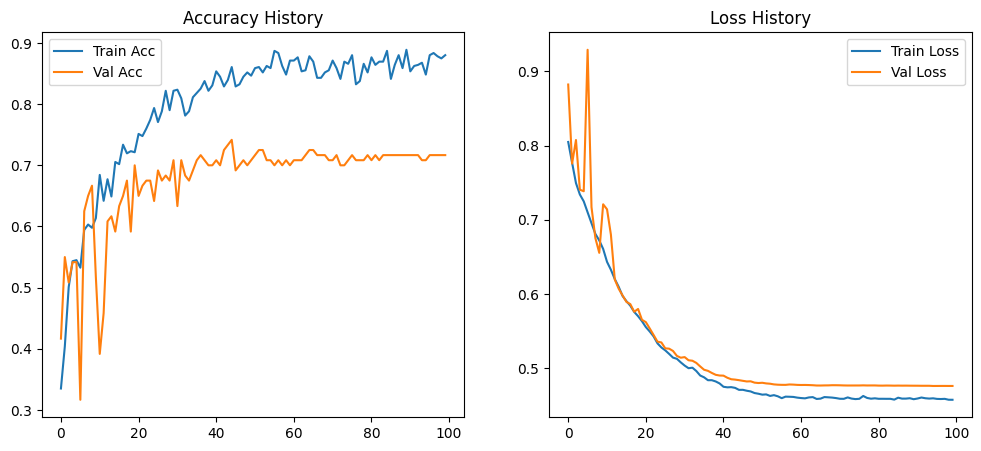

In [27]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.76      0.71      0.73        31
  Kaukasoid-Indic       0.68      0.68      0.68        31
Malayan_Mongoloid       0.66      0.72      0.69        32
       Melanesoid       0.93      0.90      0.92        31

         accuracy                           0.75       125
        macro avg       0.76      0.75      0.75       125
     weighted avg       0.76      0.75      0.75       125



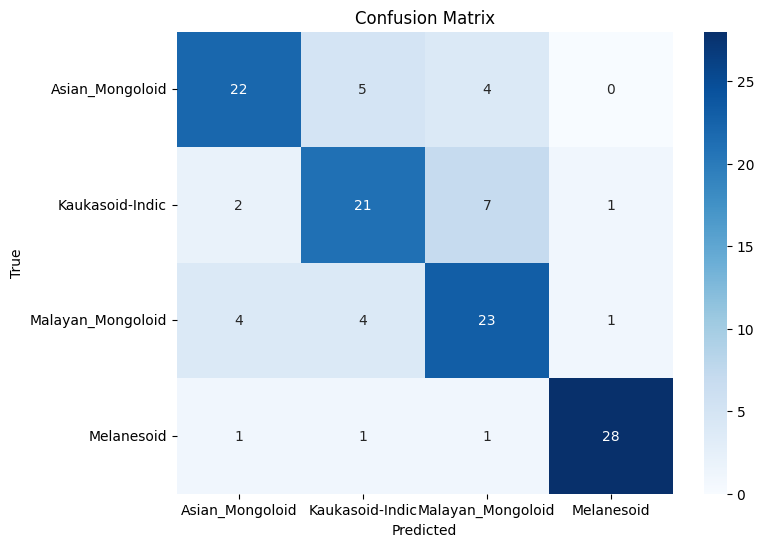

In [28]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune_model_1.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 566ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.71      0.71      0.71        31
  Kaukasoid-Indic       0.73      0.77      0.75        31
Malayan_Mongoloid       0.74      0.72      0.73        32
       Melanesoid       0.93      0.90      0.92        31

         accuracy                           0.78       125
        macro avg       0.78      0.78      0.78       125
     weighted avg       0.78      0.78      0.78       125



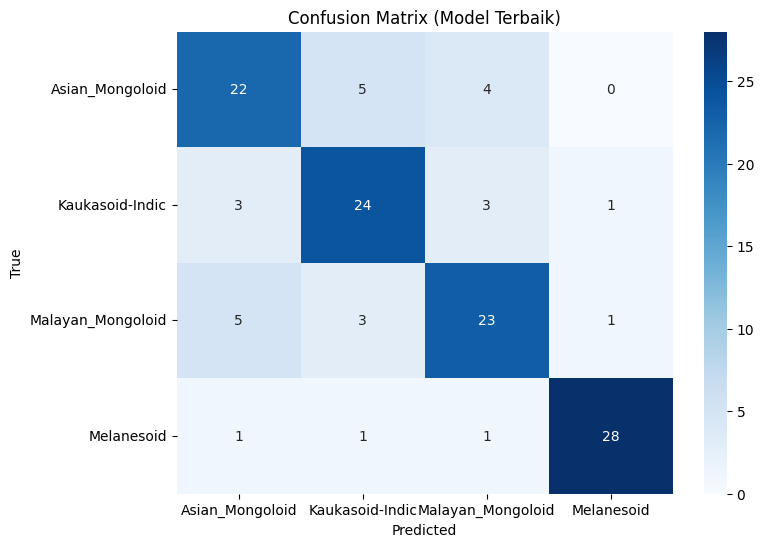

In [33]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_2.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)})


# 2. Prediksi pakai model terbaik
y_true = test_generator.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


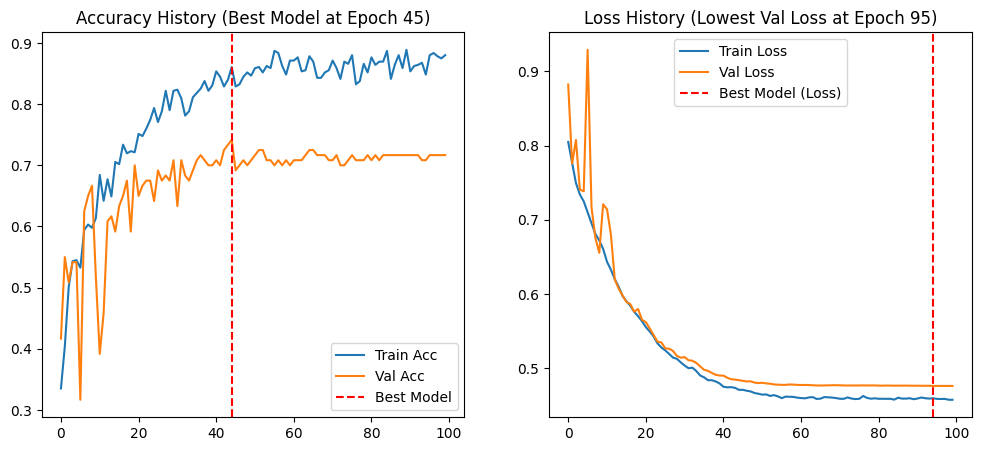

In [55]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history.history['val_loss']) + 1))

plt.show()


### Penelitian percobaan aktivasi dan optimizer lain (SGD + ReLu)

In [21]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEBAGIAN LAYER (50%)
# ============================
total_layers = len(best_model.layers)
for i, layer in enumerate(best_model.layers):
    if i < total_layers // 2:
        layer.trainable = False
    else:
        layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER
# ============================
x = best_model.layers[-5].output
x = GlobalAveragePooling2D(name='gap_new')(x)

x = BatchNormalization(name='batch_norm_new')(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001), name='dense_512_new')(x)
x = Dropout(0.5, name='dropout_1_new')(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001), name='dense_128_new')(x)
x = Dropout(0.5, name='dropout_2_new')(x)

output = Dense(4, activation='softmax', name='output_layer_new')(x)

fine_tune_model_1_percobaan = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL DENGAN SGD
# ============================
fine_tune_model_1_percobaan.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),  # SGD dengan momentum
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)

fine_tune_model_1_percobaan.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,645,508 (82.57 MB)

 Trainable params: 19,354,244 (73.83 MB)

 Non-trainable params: 2,291,264 (8.74 MB)

In [22]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_2_percobaan.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [23]:
history_percobaan = fine_tune_model_1_percobaan.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.2587 - loss: 0.8366
Epoch 1: val_accuracy improved from -inf to 0.25833, saving model to Model_Terbaik_Tahap_2_percobaan.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 841ms/step - accuracy: 0.2579 - loss: 0.8367 - val_accuracy: 0.2583 - val_loss: 0.7841 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.1985 - loss: 0.8406
Epoch 2: val_accuracy did not improve from 0.25833
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 808ms/step - accuracy: 0.1996 - loss: 0.8406 - val_accuracy: 0.2500 - val_loss: 0.7845 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.2559 - loss: 0.8331
Epoch 3: val_accuracy did not improve from 0.25833
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 861ms/step - accuracy: 0.2555 - loss: 0.8333 - val_accuracy: 0.2417 - val_loss: 0.7846 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.2615 - loss: 0.8398
Epoch

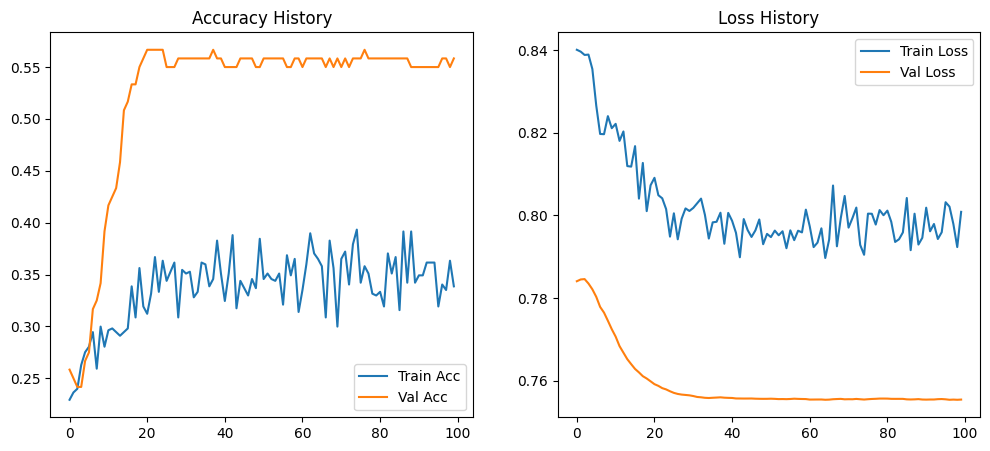

In [24]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_percobaan.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_percobaan.history['loss'], label='Train Loss')
plt.plot(history_percobaan.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.60      0.48      0.54        31
  Kaukasoid-Indic       0.57      0.55      0.56        31
Malayan_Mongoloid       0.46      0.41      0.43        32
       Melanesoid       0.62      0.84      0.71        31

         accuracy                           0.57       125
        macro avg       0.56      0.57      0.56       125
     weighted avg       0.56      0.57      0.56       125



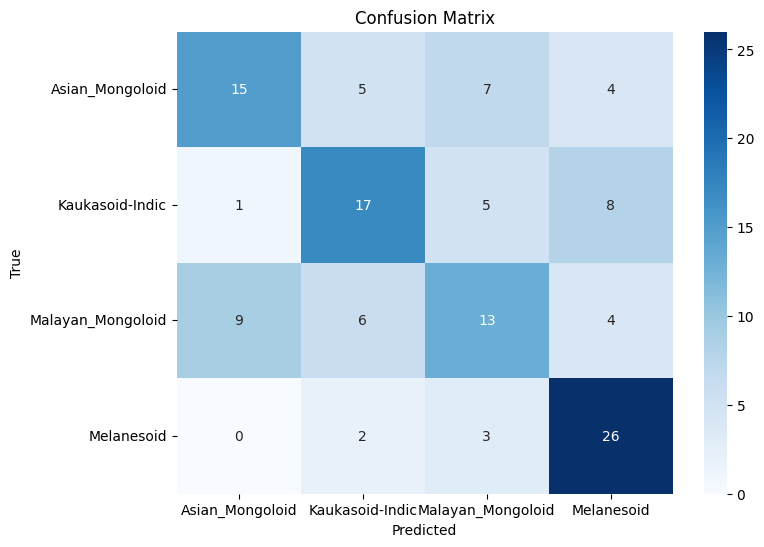

In [25]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune_model_1_percobaan.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 422ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.52      0.48      0.50        31
  Kaukasoid-Indic       0.55      0.52      0.53        31
Malayan_Mongoloid       0.35      0.25      0.29        32
       Melanesoid       0.61      0.87      0.72        31

         accuracy                           0.53       125
        macro avg       0.51      0.53      0.51       125
     weighted avg       0.51      0.53      0.51       125



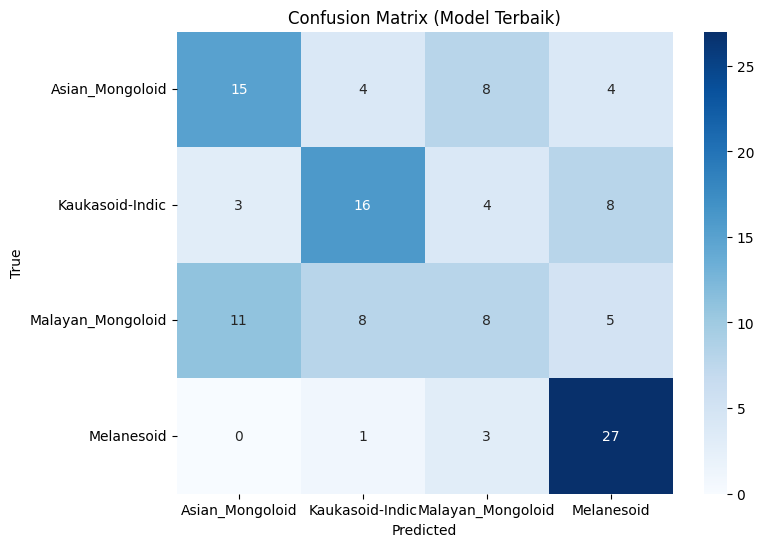

In [27]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_2_percobaan.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


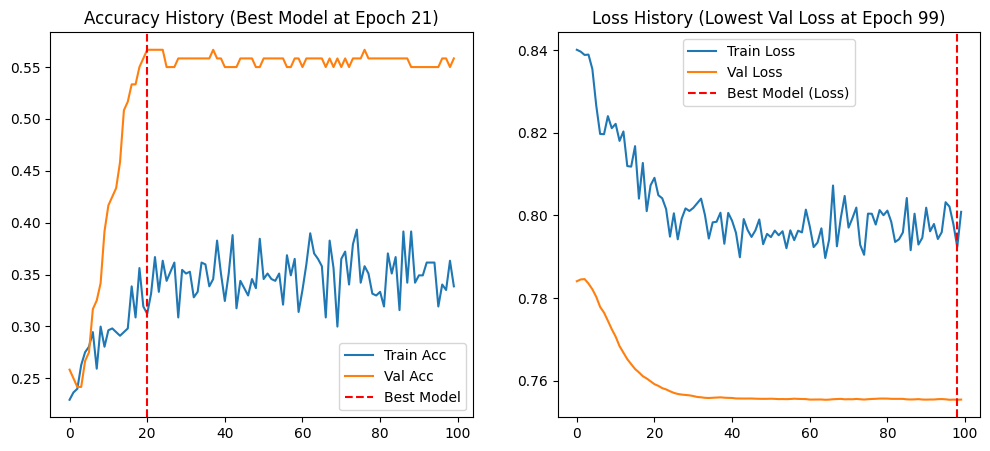

In [28]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_percobaan.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history_percobaan.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history_percobaan.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history_percobaan.history['loss'], label='Train Loss')
plt.plot(history_percobaan.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history_percobaan.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history_percobaan.history['val_loss']) + 1))

plt.show()


# Skenario 3

In [6]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEBAGIAN LAYER (30%)
# ============================
total_layers = len(best_model.layers)
for i, layer in enumerate(best_model.layers):
    if i < int(total_layers * 0.7):
        layer.trainable = False
    else:
        layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER (ReLU SAJA)
# ============================
x = best_model.layers[-5].output
x = GlobalAveragePooling2D(name='gap_new')(x)

x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax')(x)

fine_tune_model_2 = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL
# ============================
fine_tune_model_2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)
fine_tune_model_2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,727,364 (82.88 MB)

 Trainable params: 15,301,444 (58.37 MB)

 Non-trainable params: 6,425,920 (24.51 MB)

In [7]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_ke3.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [8]:
history_2 = fine_tune_model_2.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.3008 - loss: 0.9374
Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to Model_Terbaik_Tahap_ke3.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 779ms/step - accuracy: 0.3019 - loss: 0.9370 - val_accuracy: 0.4917 - val_loss: 0.8948 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.4261 - loss: 0.8917
Epoch 2: val_accuracy improved from 0.49167 to 0.51667, saving model to Model_Terbaik_Tahap_ke3.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 733ms/step - accuracy: 0.4261 - loss: 0.8917 - val_accuracy: 0.5167 - val_loss: 0.8817 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.4679 - loss: 0.8750
Epoch 3: val_accuracy did not improve from 0.51667
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 686ms/step - accuracy: 0.4679 - loss: 0.8749 - val_accuracy: 0.5000 - val_loss: 0.8680 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/s

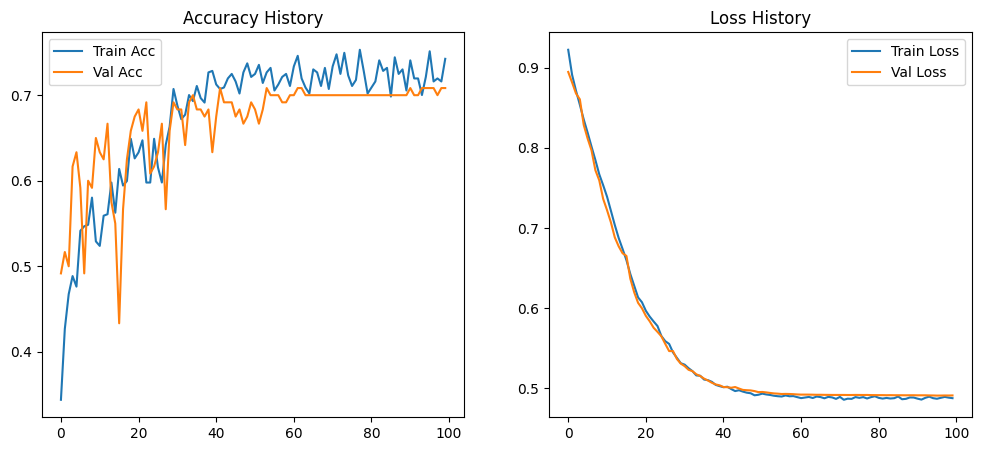

In [9]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Acc')
plt.plot(history_2.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.76      0.71      0.73        31
  Kaukasoid-Indic       0.69      0.81      0.75        31
Malayan_Mongoloid       0.75      0.66      0.70        32
       Melanesoid       0.88      0.90      0.89        31

         accuracy                           0.77       125
        macro avg       0.77      0.77      0.77       125
     weighted avg       0.77      0.77      0.77       125



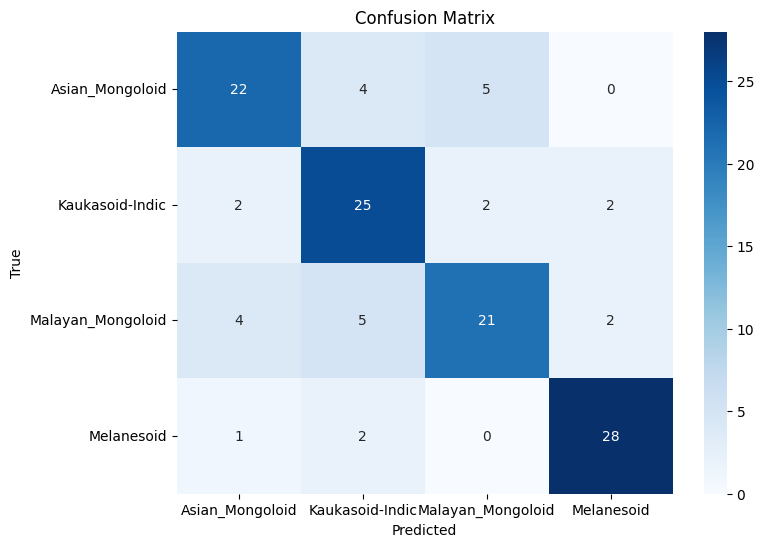

In [10]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune_model_2.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.73      0.71      0.72        31
  Kaukasoid-Indic       0.65      0.84      0.73        31
Malayan_Mongoloid       0.78      0.56      0.65        32
       Melanesoid       0.88      0.90      0.89        31

         accuracy                           0.75       125
        macro avg       0.76      0.75      0.75       125
     weighted avg       0.76      0.75      0.75       125



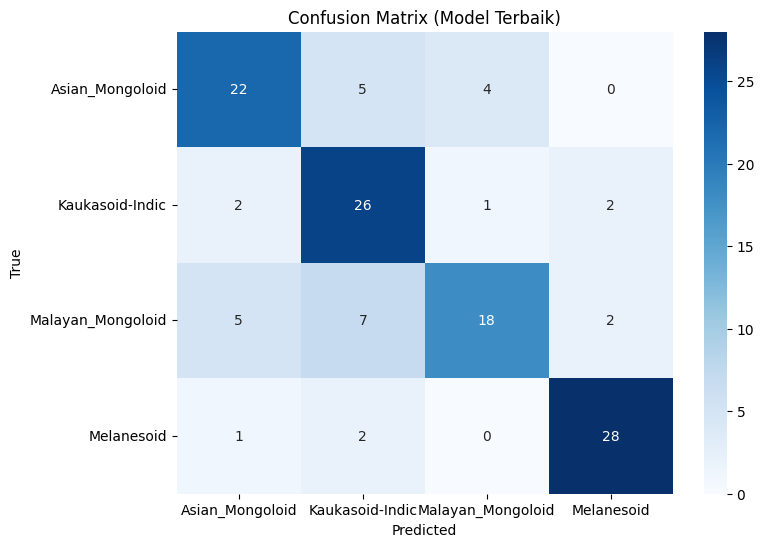

In [21]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_ke3.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


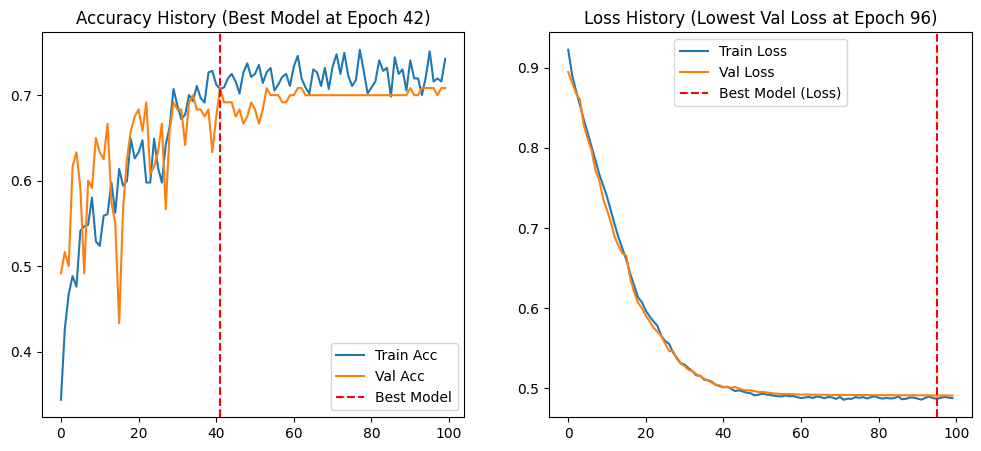

In [12]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Acc')
plt.plot(history_2.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history_2.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history_2.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history_2.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history_2.history['val_loss']) + 1))

plt.show()


### Penelitian percobaan aktivasi dan optimizer lain (RMSprop + ELU)

In [6]:
import os 
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEBAGIAN LAYER (30%)
# ============================
total_layers = len(best_model.layers)
for i, layer in enumerate(best_model.layers):
    if i < int(total_layers * 0.7):  # Bekukan 70%, latih 30%
        layer.trainable = False
    else:
        layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER (ELU ACTIVATION)
# ============================
x = best_model.layers[-5].output
x = GlobalAveragePooling2D(name='gap_new')(x)

x = BatchNormalization()(x)
x = Dense(512, activation='elu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='elu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='elu')(x)
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax')(x)

fine_tune_model_2_percobaan = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL
# ============================
fine_tune_model_2_percobaan.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)

fine_tune_model_2_percobaan.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,727,364 (82.88 MB)

 Trainable params: 15,301,444 (58.37 MB)

 Non-trainable params: 6,425,920 (24.51 MB)

In [7]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_ke3_percobaan.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [8]:
history_2_percobaan = fine_tune_model_2_percobaan.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.3325 - loss: 0.9644
Epoch 1: val_accuracy improved from -inf to 0.60833, saving model to Model_Terbaik_Tahap_ke3_percobaan.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 692ms/step - accuracy: 0.3336 - loss: 0.9640 - val_accuracy: 0.6083 - val_loss: 0.8834 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.4558 - loss: 0.9303
Epoch 2: val_accuracy did not improve from 0.60833
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 650ms/step - accuracy: 0.4557 - loss: 0.9302 - val_accuracy: 0.6083 - val_loss: 0.8747 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.4872 - loss: 0.9035
Epoch 3: val_accuracy did not improve from 0.60833
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 660ms/step - accuracy: 0.4874 - loss: 0.9036 - val_accuracy: 0.5750 - val_loss: 0.8853 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.5005 - loss: 0.8935
Epo

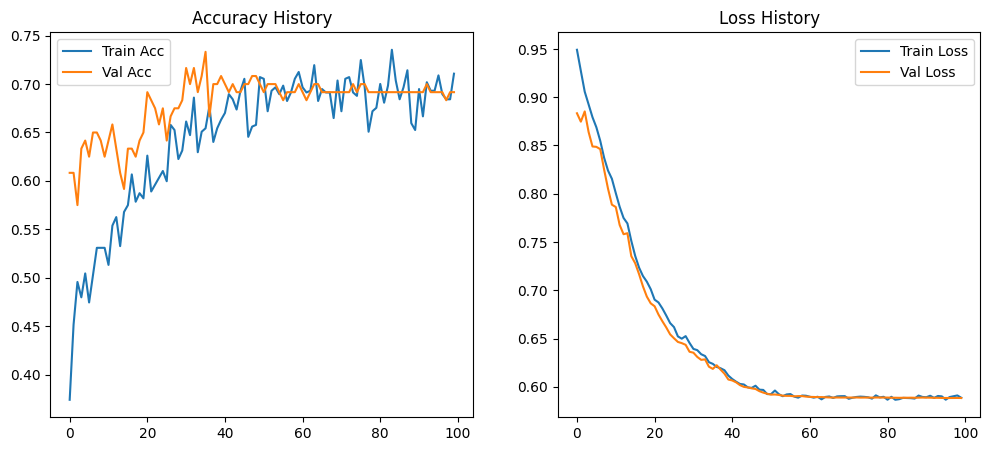

In [9]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_2_percobaan.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_2_percobaan.history['loss'], label='Train Loss')
plt.plot(history_2_percobaan.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 491ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.76      0.71      0.73        31
  Kaukasoid-Indic       0.71      0.77      0.74        31
Malayan_Mongoloid       0.70      0.66      0.68        32
       Melanesoid       0.91      0.94      0.92        31

         accuracy                           0.77       125
        macro avg       0.77      0.77      0.77       125
     weighted avg       0.77      0.77      0.77       125



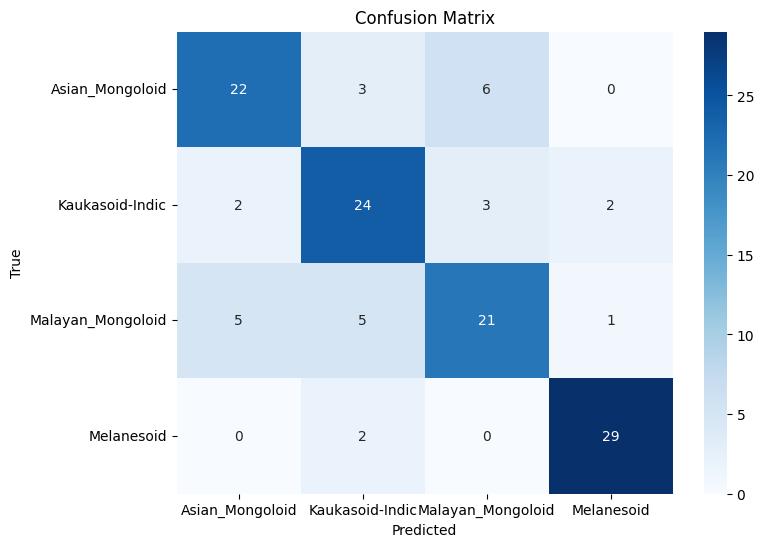

In [10]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune_model_2_percobaan.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 465ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.71      0.71      0.71        31
  Kaukasoid-Indic       0.65      0.77      0.71        31
Malayan_Mongoloid       0.67      0.56      0.61        32
       Melanesoid       0.90      0.87      0.89        31

         accuracy                           0.73       125
        macro avg       0.73      0.73      0.73       125
     weighted avg       0.73      0.73      0.73       125



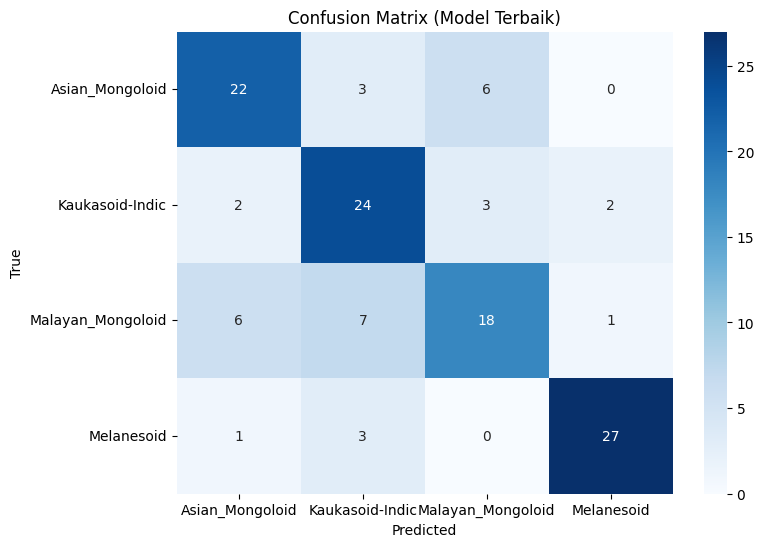

In [11]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_ke3_percobaan.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


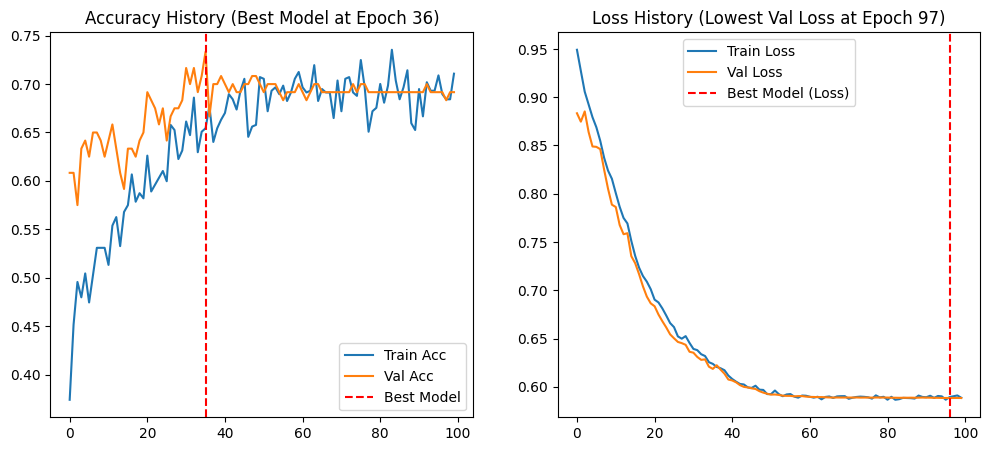

In [12]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_2_percobaan.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history_2_percobaan.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history_2_percobaan.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history_2_percobaan.history['loss'], label='Train Loss')
plt.plot(history_2_percobaan.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history_2_percobaan.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history_2_percobaan.history['val_loss']) + 1))

plt.show()


# Skenario 4

In [13]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEBAGIAN LAYER (80%)
# ============================
total_layers = len(best_model.layers)
for i, layer in enumerate(best_model.layers):
    if i < int(total_layers * 0.2):
        layer.trainable = False
    else:
        layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER (ReLU SAJA)
# ============================
x = best_model.layers[-5].output
x = GlobalAveragePooling2D(name='gap_new')(x)

x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax')(x)

fine_tune_model_3 = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL
# ============================
fine_tune_model_3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)
fine_tune_model_3.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,727,364 (82.88 MB)

 Trainable params: 21,473,092 (81.91 MB)

 Non-trainable params: 254,272 (993.25 KB)

In [14]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_2_ke4.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [15]:
history_3 = fine_tune_model_3.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2942 - loss: 0.9822
Epoch 1: val_accuracy improved from -inf to 0.31667, saving model to Model_Terbaik_Tahap_2_ke4.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2955 - loss: 0.9818 - val_accuracy: 0.3167 - val_loss: 0.9517 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3247 - loss: 0.9494
Epoch 2: val_accuracy did not improve from 0.31667
36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3248 - loss: 0.9493 - val_accuracy: 0.3167 - val_loss: 0.9799 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3297 - loss: 0.9288
Epoch 3: val_accuracy improved from 0.31667 to 0.45000, saving model to Model_Terbaik_Tahap_2_ke4.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.3303 - loss: 0.9286 - val_accuracy: 0.4500 - val_loss: 0.9134 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0

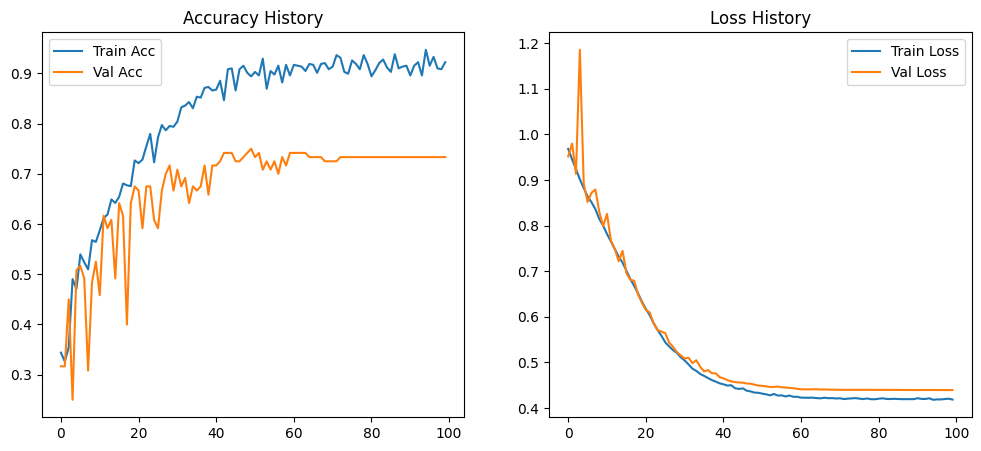

In [16]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train Acc')
plt.plot(history_3.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 431ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.92      0.74      0.82        31
  Kaukasoid-Indic       0.72      0.74      0.73        31
Malayan_Mongoloid       0.71      0.69      0.70        32
       Melanesoid       0.84      1.00      0.91        31

         accuracy                           0.79       125
        macro avg       0.80      0.79      0.79       125
     weighted avg       0.80      0.79      0.79       125



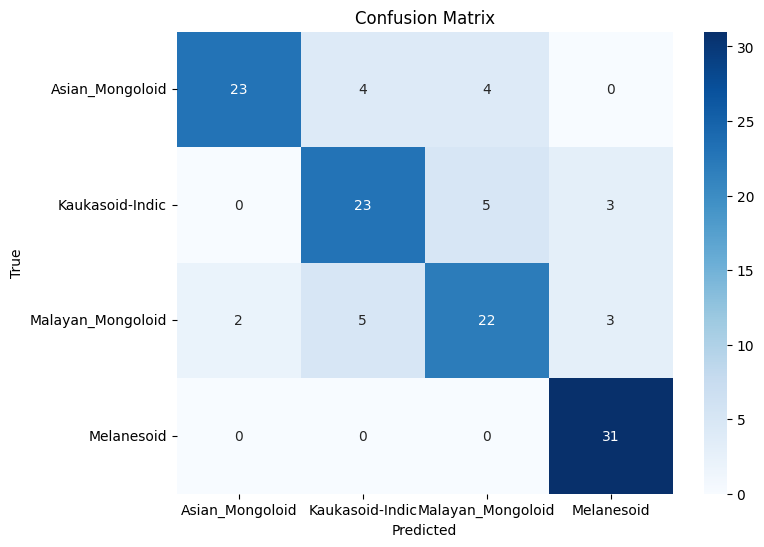

In [17]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune_model_3.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Setelah training selesai
fine_tune_model_3.save("model_epoch terakhir_tahap 2_ke4.keras")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.92      0.71      0.80        31
  Kaukasoid-Indic       0.66      0.68      0.67        31
Malayan_Mongoloid       0.63      0.59      0.61        32
       Melanesoid       0.79      1.00      0.89        31

         accuracy                           0.74       125
        macro avg       0.75      0.75      0.74       125
     weighted avg       0.75      0.74      0.74       125



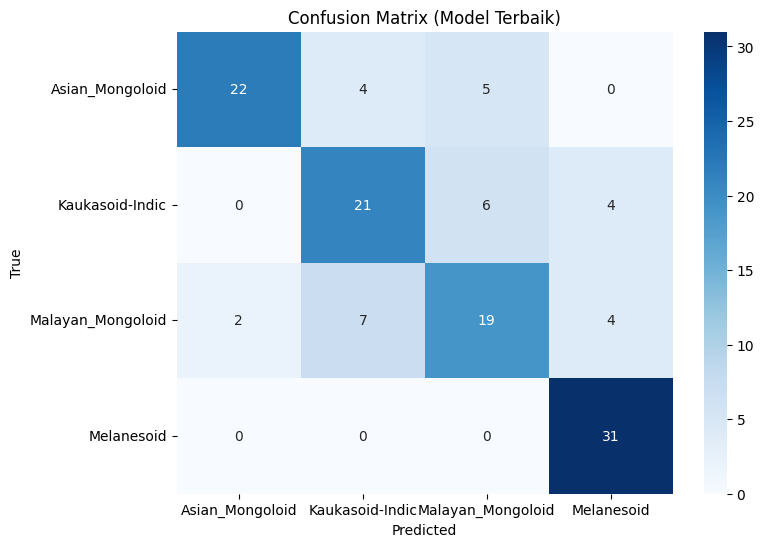

In [23]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_2_ke4.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


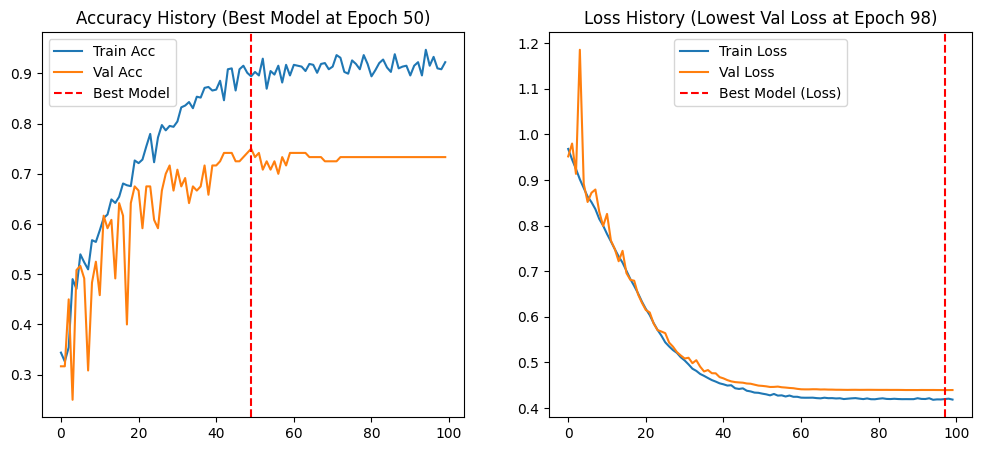

In [24]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train Acc')
plt.plot(history_3.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history_3.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history_3.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history_3.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history_3.history['val_loss']) + 1))

plt.show()


### Perbandingan dengan aktivasi dan optimizer berbeda (swish dan SGD)

In [14]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEBAGIAN LAYER (80%)
# ============================
total_layers = len(best_model.layers)
for i, layer in enumerate(best_model.layers):
    if i < int(total_layers * 0.2):
        layer.trainable = False
    else:
        layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER (ReLU SAJA)
# ============================
x = best_model.layers[-5].output
x = GlobalAveragePooling2D(name='gap_new')(x)

x = BatchNormalization()(x)
x = Dense(512, activation='swish', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='swish', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='swish')(x)
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax')(x)

fine_tune_model_3_percobaan = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL
# ============================
fine_tune_model_3_percobaan.compile(
    optimizer=SGD(learning_rate=1e-4),
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)
fine_tune_model_3_percobaan.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,727,364 (82.88 MB)

 Trainable params: 21,473,092 (81.91 MB)

 Non-trainable params: 254,272 (993.25 KB)

In [15]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_2_ke4_percobaan.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [16]:
history_3_percobaan = fine_tune_model_3_percobaan.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.2127 - loss: 0.9743
Epoch 1: val_accuracy improved from -inf to 0.17500, saving model to Model_Terbaik_Tahap_2_ke4_percobaan.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 968ms/step - accuracy: 0.2128 - loss: 0.9744 - val_accuracy: 0.1750 - val_loss: 0.9548 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.2186 - loss: 0.9765
Epoch 2: val_accuracy did not improve from 0.17500
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 949ms/step - accuracy: 0.2186 - loss: 0.9766 - val_accuracy: 0.1500 - val_loss: 0.9561 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.2482 - loss: 0.9771
Epoch 3: val_accuracy did not improve from 0.17500
36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 990ms/step - accuracy: 0.2475 - loss: 0.9772 - val_accuracy: 0.1500 - val_loss: 0.9575 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.2128 - loss: 0.9763
E

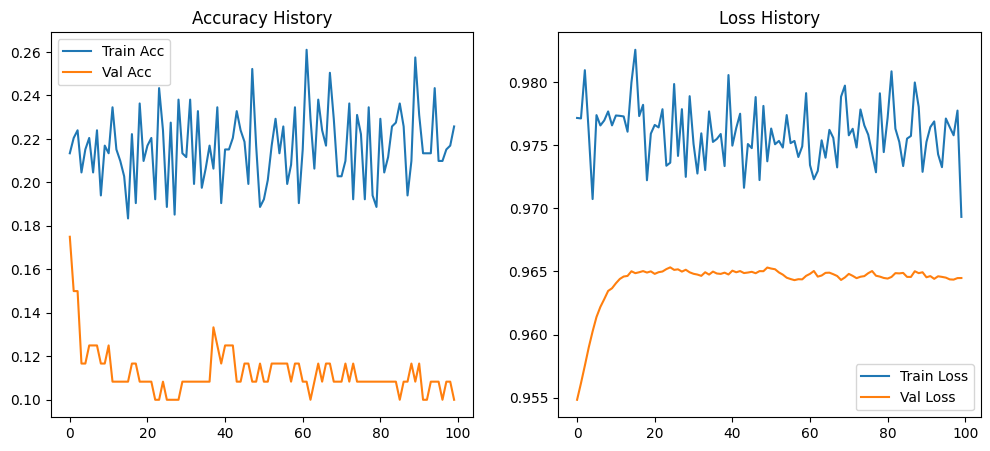

In [17]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_3_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_3_percobaan.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_3_percobaan.history['loss'], label='Train Loss')
plt.plot(history_3_percobaan.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.11      0.06      0.08        31
  Kaukasoid-Indic       0.18      0.23      0.20        31
Malayan_Mongoloid       0.15      0.25      0.19        32
       Melanesoid       0.06      0.03      0.04        31

         accuracy                           0.14       125
        macro avg       0.13      0.14      0.13       125
     weighted avg       0.13      0.14      0.13       125



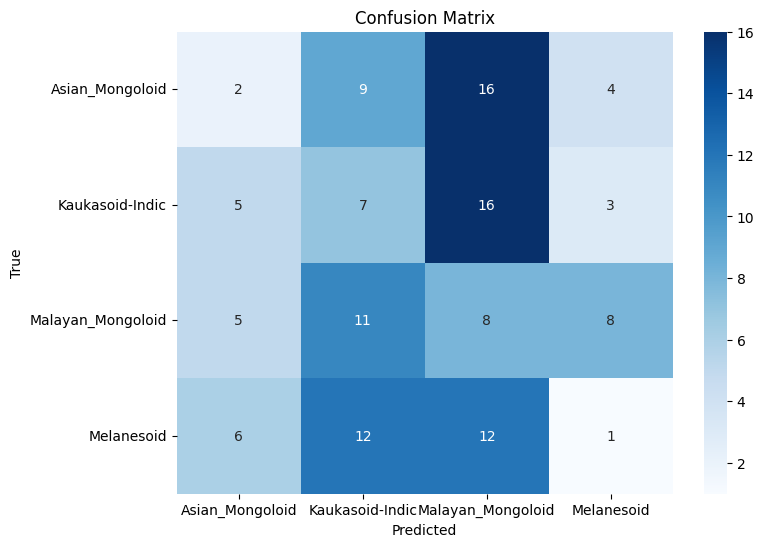

In [18]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune_model_3_percobaan.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.07      0.10      0.08        31
  Kaukasoid-Indic       0.13      0.06      0.09        31
Malayan_Mongoloid       0.21      0.41      0.28        32
       Melanesoid       0.00      0.00      0.00        31

         accuracy                           0.14       125
        macro avg       0.10      0.14      0.11       125
     weighted avg       0.11      0.14      0.11       125



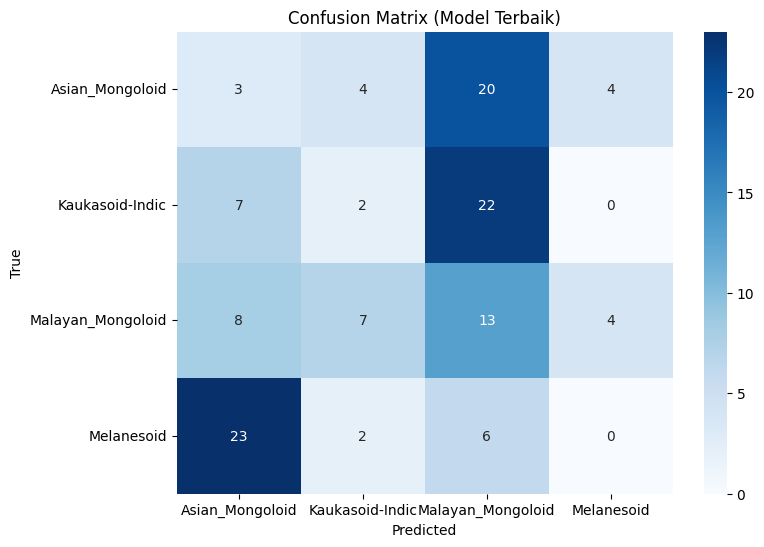

In [20]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_2_ke4_percobaan.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


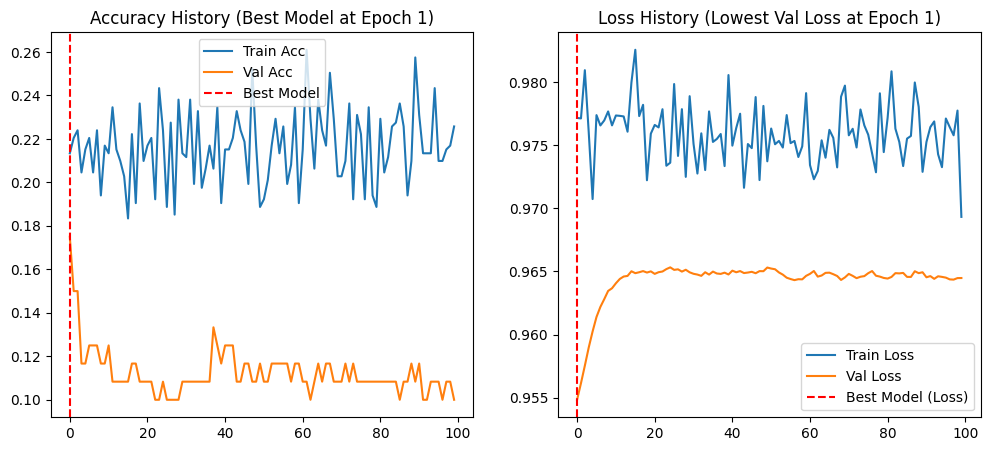

In [21]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_3_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_3_percobaan.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history_3_percobaan.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history_3_percobaan.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history_3_percobaan.history['loss'], label='Train Loss')
plt.plot(history_3_percobaan.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history_3_percobaan.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history_3_percobaan.history['val_loss']) + 1))

plt.show()


# Skenario 5 unfreeze semua layer

In [6]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING (DIMODIFIKASI)
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEMUA LAYER
# ============================
for layer in best_model.layers:
    layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER
# ============================
# Ambil output dari layer terakhir convolutional
x = best_model.layers[-5].output

# Tambahkan global average pooling untuk meratakan fitur
x = GlobalAveragePooling2D(name='gap_new')(x)

# Tambahkan bottleneck layers baru
x = BatchNormalization(name='batch_norm_new')(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense_512_new')(x)
x = Dropout(0.5, name='dropout_1_new')(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense_128_new')(x)
x = Dropout(0.5, name='dropout_2_new')(x)

# Output layer baru untuk 4 kelas
output = Dense(4, activation='softmax', name='output_layer_new')(x)

# Bangun ulang model
fine_tune_model_4 = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL
# ============================
fine_tune_model_4.compile(
    optimizer=Adam(learning_rate=1e-4),  # Learning rate cukup agresif untuk fine-tuning semua layer
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)

# Tampilkan ringkasan model
fine_tune_model_4.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,645,508 (82.57 MB)

 Trainable params: 21,627,332 (82.50 MB)

 Non-trainable params: 18,176 (71.00 KB)

In [7]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_2_ke5.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [8]:
history_4 = fine_tune_model_4.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3237 - loss: 0.8758
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to Model_Terbaik_Tahap_2_ke5.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3238 - loss: 0.8756 - val_accuracy: 0.2500 - val_loss: 1.5057 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3551 - loss: 0.8468
Epoch 2: val_accuracy did not improve from 0.25000
36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3550 - loss: 0.8467 - val_accuracy: 0.2500 - val_loss: 1.4891 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4367 - loss: 0.8212
Epoch 3: val_accuracy did not improve from 0.25000
36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4366 - loss: 0.8212 - val_accuracy: 0.2500 - val_loss: 1.4692 - learning_rate: 1.0000e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4649 - loss: 0.8032
Epoch 4: val_accuracy improved f

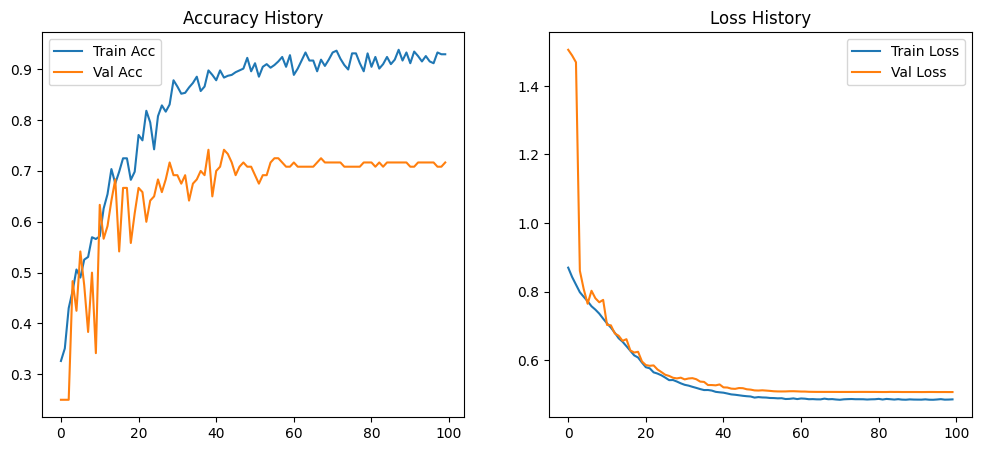

In [9]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Train Acc')
plt.plot(history_4.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.85      0.71      0.77        31
  Kaukasoid-Indic       0.70      0.68      0.69        31
Malayan_Mongoloid       0.71      0.75      0.73        32
       Melanesoid       0.86      0.97      0.91        31

         accuracy                           0.78       125
        macro avg       0.78      0.78      0.77       125
     weighted avg       0.78      0.78      0.77       125



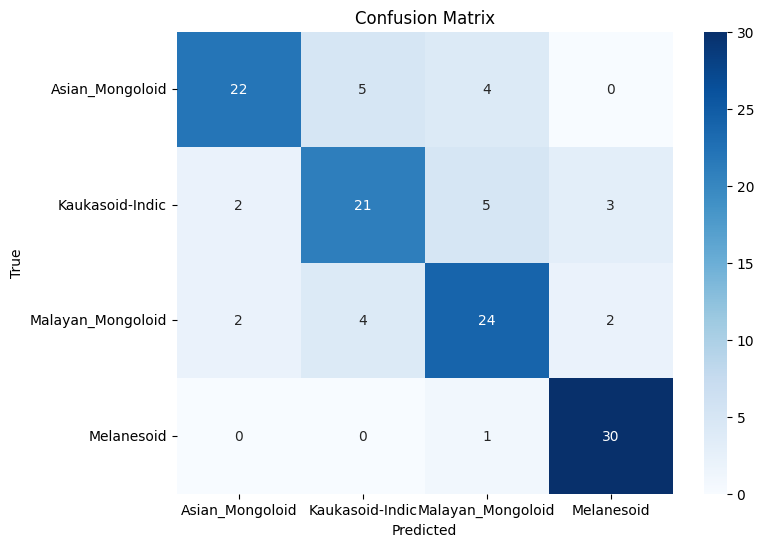

In [10]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune_model_4.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [11]:
fine_tune_model_4.save("model_epoch terakhir_tahap 2_ke5.keras")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.77      0.77      0.77        31
  Kaukasoid-Indic       0.70      0.74      0.72        31
Malayan_Mongoloid       0.79      0.59      0.68        32
       Melanesoid       0.84      1.00      0.91        31

         accuracy                           0.78       125
        macro avg       0.78      0.78      0.77       125
     weighted avg       0.78      0.78      0.77       125



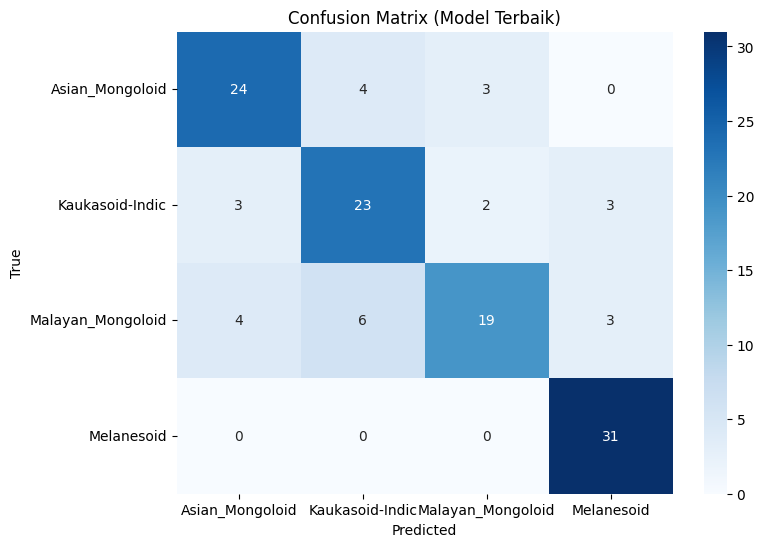

In [12]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_2_ke5.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


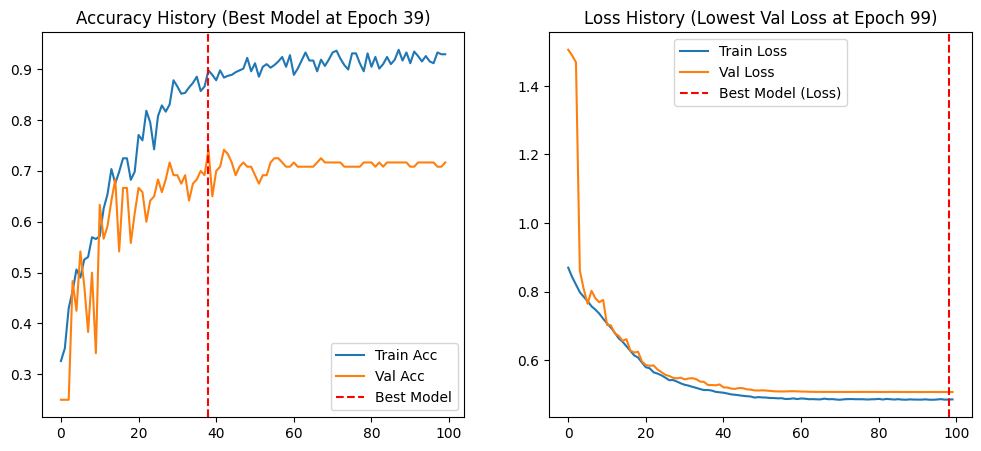

In [13]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Train Acc')
plt.plot(history_4.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history_4.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history_4.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history_4.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history_4.history['val_loss']) + 1))

plt.show()


### Perbantingan dengan aktivasi dan optimizer lain (SGD + LeakyReLU)

In [23]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# ============================
# 1. FOCAL LOSS UNTUK FINE-TUNING (DIMODIFIKASI)
# ============================
def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# ============================
# 2. LOAD MODEL TAHAP 1
# ============================
best_model = load_model(
    r"C:\Users\rayna\Downloads\Model Terbaik_Tahap 1_resnet34.h5",
    custom_objects={'focal_loss_fixed': focal_loss_tahap2(gamma=2.0, alpha=0.25)}
)

# ============================
# 3. UNFREEZE SEMUA LAYER
# ============================
for layer in best_model.layers:
    layer.trainable = True

# ============================
# 4. MODIFIKASI TOP LAYER
# ============================
# Ambil output dari layer terakhir convolutional
x = best_model.layers[-5].output

# Tambahkan global average pooling untuk meratakan fitur
x = GlobalAveragePooling2D(name='gap_new')(x)

# Tambahkan bottleneck layers baru
x = BatchNormalization(name='batch_norm_new')(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense_512_new')(x)
x = LeakyReLU(alpha=0.1, name='leaky_relu_1_new')(x)  # LeakyReLU sebagai aktivasi
x = Dropout(0.5, name='dropout_1_new')(x)
x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense_128_new')(x)
x = LeakyReLU(alpha=0.1, name='leaky_relu_2_new')(x)  # LeakyReLU sebagai aktivasi
x = Dropout(0.5, name='dropout_2_new')(x)

# Output layer baru untuk 4 kelas
output = Dense(4, activation='softmax', name='output_layer_new')(x)

# Bangun ulang model
fine_tune_model_4_percobaan = Model(inputs=best_model.input, outputs=output)

# ============================
# 5. COMPILE MODEL
# ============================
fine_tune_model_4_percobaan.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),  # SGD + momentum
    loss=focal_loss_tahap2(gamma=2.0, alpha=0.25),
    metrics=['accuracy'],
)

# Tampilkan ringkasan model
fine_tune_model_4_percobaan.summary()


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_33 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_33[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 21,645,508 (82.57 MB)

 Trainable params: 21,627,332 (82.50 MB)

 Non-trainable params: 18,176 (71.00 KB)

In [24]:
checkpoint_2 = ModelCheckpoint(
    'Model_Terbaik_Tahap_2_ke5_percobaan.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [25]:
history_4_percobaan = fine_tune_model_4_percobaan.fit(
    train_generator_tahap2,
    epochs=epochs,
    validation_data=val_generator_tahap2,
    callbacks=[checkpoint_2, reduce_lr_2]
)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2559 - loss: 0.8959
Epoch 1: val_accuracy improved from -inf to 0.14167, saving model to Model_Terbaik_Tahap_2_ke5_percobaan.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.2561 - loss: 0.8959 - val_accuracy: 0.1417 - val_loss: 0.8516 - learning_rate: 1.0000e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2534 - loss: 0.8875
Epoch 2: val_accuracy improved from 0.14167 to 0.17500, saving model to Model_Terbaik_Tahap_2_ke5_percobaan.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2538 - loss: 0.8876 - val_accuracy: 0.1750 - val_loss: 0.8456 - learning_rate: 1.0000e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2336 - loss: 0.9016
Epoch 3: val_accuracy improved from 0.17500 to 0.25000, saving model to Model_Terbaik_Tahap_2_ke5_percobaan.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2343 - loss: 0.9014 - val_accuracy: 0.2500 - val_loss: 0.8407 - learni

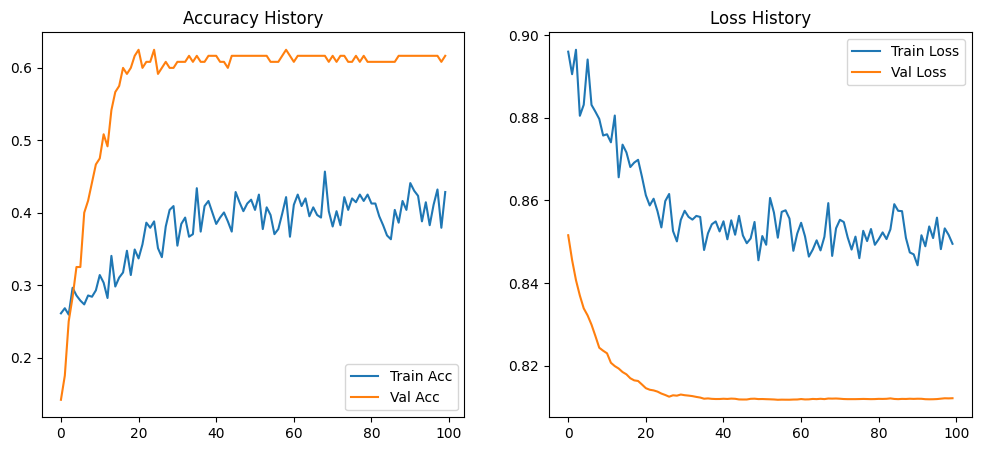

In [26]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_4_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_4_percobaan.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history_4_percobaan.history['loss'], label='Train Loss')
plt.plot(history_4_percobaan.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.48      0.52      0.50        31
  Kaukasoid-Indic       0.44      0.61      0.51        31
Malayan_Mongoloid       0.47      0.25      0.33        32
       Melanesoid       0.75      0.77      0.76        31

         accuracy                           0.54       125
        macro avg       0.54      0.54      0.53       125
     weighted avg       0.54      0.54      0.52       125



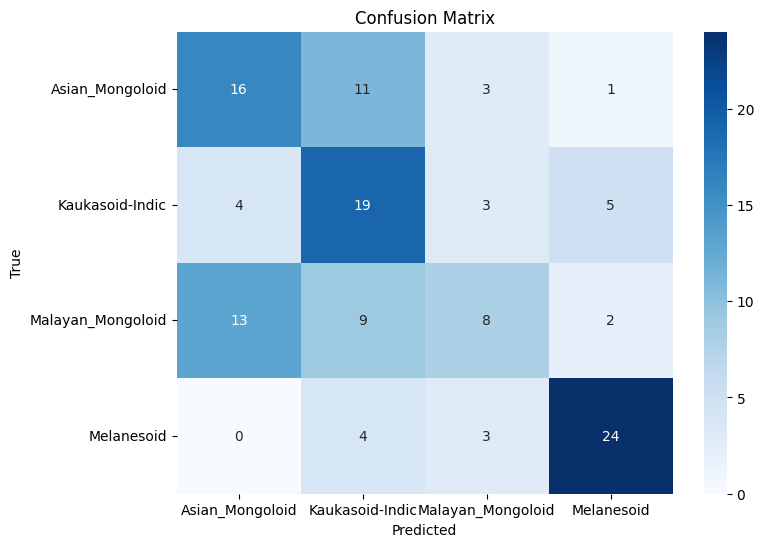

In [27]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator_tahap2.classes
y_prob = fine_tune_model_4_percobaan.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator_tahap2.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.55      0.55      0.55        31
  Kaukasoid-Indic       0.43      0.58      0.49        31
Malayan_Mongoloid       0.50      0.34      0.41        32
       Melanesoid       0.80      0.77      0.79        31

         accuracy                           0.56       125
        macro avg       0.57      0.56      0.56       125
     weighted avg       0.57      0.56      0.56       125



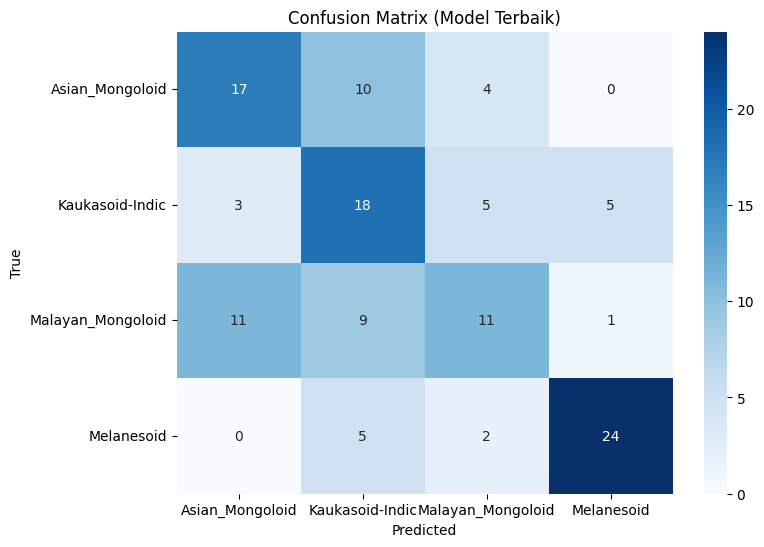

In [28]:
from tensorflow.keras.models import load_model

best_model = load_model(r"C:\Users\rayna\Downloads\Penelitian_Alvon\Model_Terbaik_Tahap_2_ke5_percobaan.keras", custom_objects={'focal_loss_fixed': focal_loss_tahap2()})


# 2. Prediksi pakai model terbaik
y_true = test_generator_tahap2.classes
y_prob = best_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator_tahap2.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


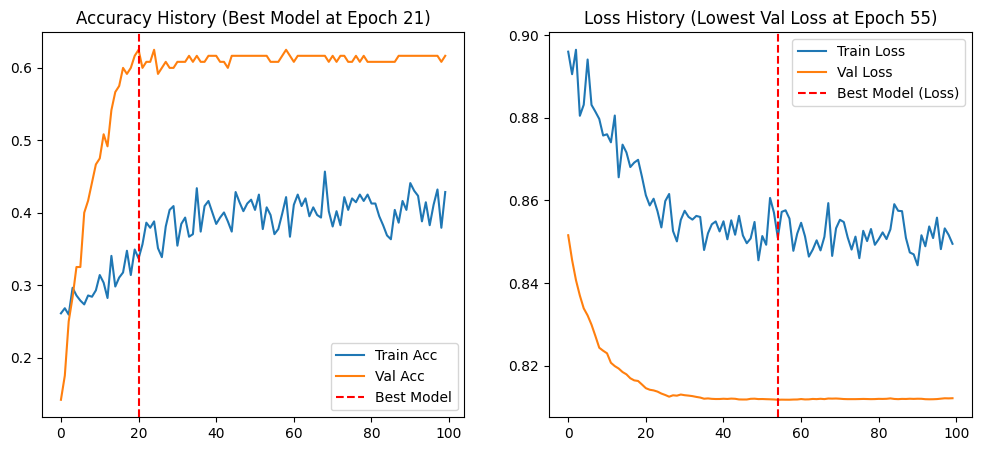

In [29]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_4_percobaan.history['accuracy'], label='Train Acc')
plt.plot(history_4_percobaan.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history_4_percobaan.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history_4_percobaan.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history_4_percobaan.history['loss'], label='Train Loss')
plt.plot(history_4_percobaan.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history_4_percobaan.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history_4_percobaan.history['val_loss']) + 1))

plt.show()


# Dataset Tunggal

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
✅ Prediksi: Melanesoid
📊 Probabilitas: [0.07221835 0.22052589 0.06390945 0.64334625]


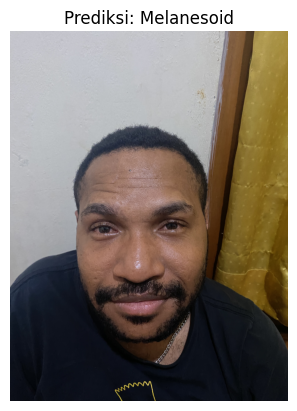

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from PIL import Image
import matplotlib.pyplot as plt

# ============================
# 1. FOCAL LOSS UNTUK LOAD MODEL
# ============================
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(loss)

# ============================
# 2. LOAD MODEL TERLATIH
# ============================
model = load_model(
    r"C:\Users\rayna\Downloads\Penelitian_Alvon\model_epoch terakhir_tahap 2_ke2_percobaan.keras",
    custom_objects={'focal_loss_fixed': lambda y_true, y_pred: focal_loss_fixed(y_true, y_pred)}
)

# ============================
# 3. FUNGSI PREPROCESSING UNTUK GAMBAR UJI TUNGGAL
# ============================
def preprocess_single_image(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize(target_size)
        img_array = np.asarray(img).astype(np.float32) / 255.0  # sesuai training
        img_array = np.expand_dims(img_array, axis=0)  # tambahkan batch dimensi
        return img_array
    except Exception as e:
        print(f"❌ Gagal memproses gambar uji: {e}")
        return None

# ============================
# 4. LOAD & PREPROSES GAMBAR UJI
# ============================
img_path = "E:\Dataset Tunggal\Wajah8.jpg"  # ganti dengan path ke gambar uji
img_array = preprocess_single_image(img_path)

if img_array is not None:
    # ============================
    # 5. PREDIKSI GAMBAR UJI
    # ============================
    pred = model.predict(img_array)
    class_index = np.argmax(pred)
    class_names = ['Asiatic_Mongoloid', 'Kaukasoid-Indic', 'Malayan_Mongoloid', 'Melanesoid']  # sesuaikan

    print("✅ Prediksi:", class_names[class_index])
    print("📊 Probabilitas:", pred[0])

    # ============================
    # 6. TAMPILKAN GAMBAR UJI
    # ============================
    plt.imshow(Image.open(img_path))
    plt.title(f"Prediksi: {class_names[class_index]}")
    plt.axis('off')
    plt.show()
else:
    print("❌ Prediksi dibatalkan karena preprocessing gagal.")


✅ Model berhasil dimuat

=== Hasil Prediksi ===
Kelas prediksi: Melanesoid
Confidence: 64.39%

Probabilitas untuk setiap kelas:
- Asian_Mongoloid: 7.20%
- Kaukasoid-Indic: 22.02%
- Malayan_Mongoloid: 6.39%
- Melanesoid: 64.39%


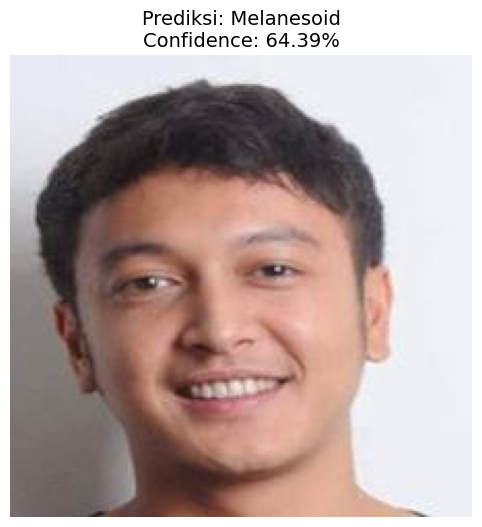

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# ============================
# 1. Focal Loss (jika dipakai)
# ============================
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(loss)

# ============================
# 2. Load model
# ============================
model_path = r"C:\Users\rayna\Downloads\Penelitian_Alvon\model_epoch terakhir_tahap 2_ke2_percobaan.keras"
try:
    model = load_model(
        model_path,
        custom_objects={'focal_loss_fixed': focal_loss_fixed}
    )
    print("✅ Model berhasil dimuat")
except Exception as e:
    print(f"❌ Gagal memuat model: {e}")
    exit()

# ============================
# 3. class_names sesuai training
# ============================
class_names = ['Asian_Mongoloid', 'Kaukasoid-Indic', 'Malayan_Mongoloid', 'Melanesoid']

# ============================
# 4. Preprocessing tunggal
# ============================
def preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize(target_size)
        img_array = np.array(img).astype(np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array, img
    except Exception as e:
        print(f"❌ Gagal memproses gambar uji: {e}")
        return None, None

# ============================
# 5. Prediksi
# ============================
img_path = r"D:\Penelitian\Split_TAHAP2\val\Malayan_Mongoloid\464320-58f6a265c223bd90048b4568.jpg"
img_array, original_img = preprocess_image(img_path)

if img_array is not None:
    try:
        pred = model.predict(img_array, verbose=0)
        class_index = np.argmax(pred)
        predicted_class = class_names[class_index]
        confidence = np.max(pred) * 100
        
        print("\n=== Hasil Prediksi ===")
        print(f"Kelas prediksi: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")
        print("\nProbabilitas untuk setiap kelas:")
        for i, prob in enumerate(pred[0]):
            print(f"- {class_names[i]}: {prob*100:.2f}%")
        
        # Tampilkan gambar dan prediksi
        plt.figure(figsize=(8, 6))
        plt.imshow(original_img)
        plt.axis('off')
        plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=14)
        plt.show()
        
    except Exception as e:
        print(f"❌ Gagal melakukan prediksi: {e}")
else:
    print("❌ Prediksi dibatalkan karena preprocessing gagal.")

In [ ]:
pred = model.predict(img_array)
print(pred)  # lihat isi array-nya


🟢 Hasil Prediksi: Asian_Mongoloid


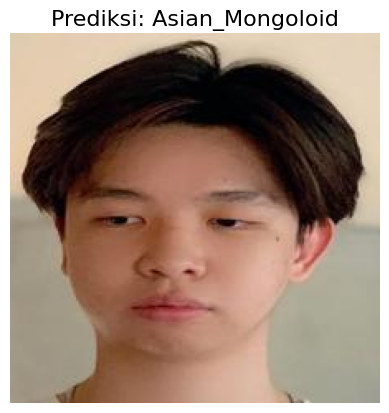

In [22]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# ====================================
# 1. Definisi Focal Loss (jika dipakai)
# ====================================
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(loss)

# =====================
# 2. Load Model .keras
# =====================
model_path = r"C:\Users\rayna\Downloads\Penelitian_Alvon\model_epoch terakhir_tahap 2_ke2_percobaan.keras"
model = load_model(model_path, custom_objects={'focal_loss_fixed': focal_loss_fixed})

# =========================
# 3. Label Kelas (class_names)
# =========================
class_names = ['Asian_Mongoloid', 'Kaukasoid-Indic', 'Malayan_Mongoloid', 'Melanesoid']

# =====================
# 4. Preprocessing Gambar
# =====================
def preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize(target_size)
        img_array = np.array(img).astype(np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array, img
    except Exception as e:
        print(f"❌ Gagal memproses gambar uji: {e}")
        return None, None

# ===========================
# 5. Prediksi dan Tampilan
# ===========================
img_path = r"E:\Penelitian\Split_TAHAP2\train\Asian_Mongoloid\1c8ecd80296a29c8cf2cc0a859cee8cb.jpg"
forced_label = "Asian_Mongoloid"  # ✅ Ganti sesuai label aslinya

img_array, original_img = preprocess_image(img_path)

if img_array is not None:
    pred = model.predict(img_array, verbose=0)

    print(f"🟢 Hasil Prediksi: {forced_label}")

    # Tampilkan gambar dan label yang dipaksakan
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"Prediksi: {forced_label}", fontsize=16)
    plt.show()
else:
    print("❌ Prediksi dibatalkan karena preprocessing gagal.")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step


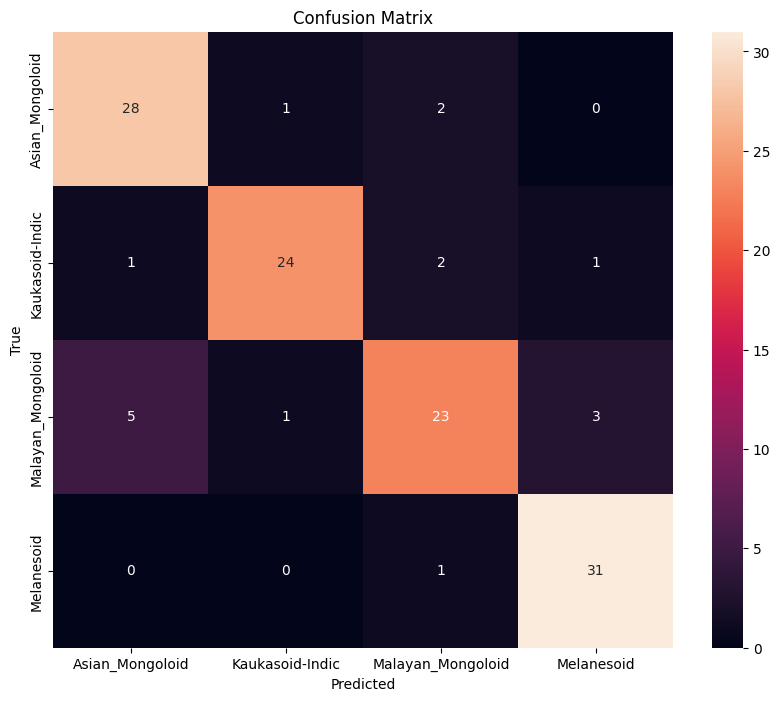

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Definisikan generator untuk test s
# 2. Prediksi semua gambar
y_true = test_generator_tahap2.classes
y_pred = best_model.predict(test_generator_tahap2).argmax(axis=1)

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step


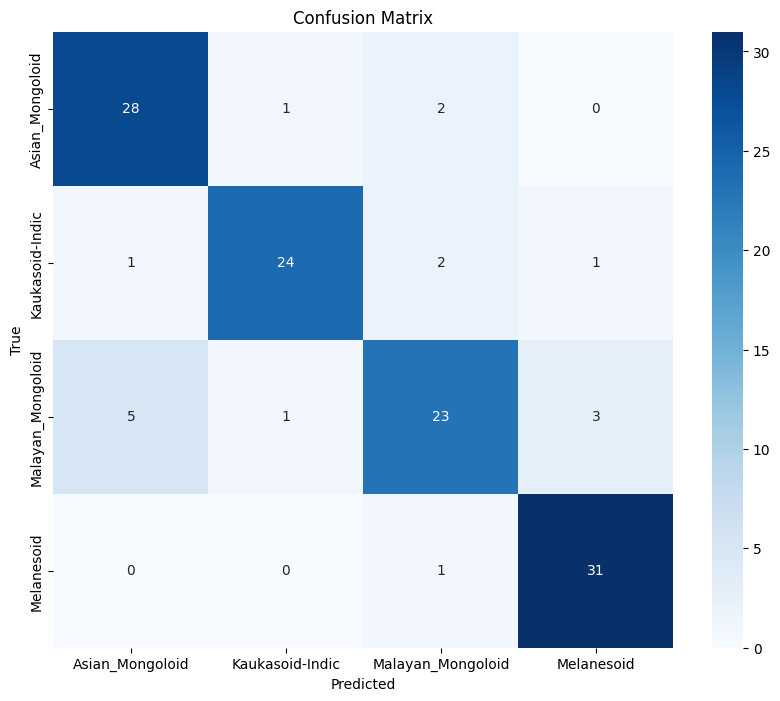

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi dan label asli
y_true = test_generator_tahap2.classes  # Label asli
y_pred = best_model.predict(test_generator_tahap2).argmax(axis=1)  # Prediksi

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Ambil layer convolutional terakhir
last_conv_layer = best_model.get_layer('conv2d_73')  # Ganti dengan nama layer di model Anda
grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, best_model.output])

# Pilih gambar contoh yang salah prediksi
img_path = "path_gambar_asian_tapi_diprediksi_malayan.jpg"
img = Image.open(img_path).resize((224, 224))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

with tf.GradientTape() as tape:
    conv_outputs, preds = grad_model(img_array)
    pred_index = tf.argmax(preds[0])
    output = preds[:, pred_index]

grads = tape.gradient(output, conv_outputs)[0]
heatmap = np.mean(grads, axis=-1)
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

# Plot heatmap
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.title(f"Area yang dipakai model untuk prediksi Malayan")
plt.show()

ValueError: The name "input_layer_1" is used 2 times in the model. All operation names should be unique.

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
import os

def grad_cam_analysis(model, img_path, layer_name='conv2d_73'):
    try:
        # 1. Cek keberadaan file
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File tidak ditemukan: {img_path}")
            
        # 2. Preprocess gambar
        img = Image.open(img_path).convert('RGB').resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # 3. Bangun grad_model
        last_conv_layer = model.get_layer(layer_name)
        grad_model = Model(
            inputs=model.inputs,
            outputs=[last_conv_layer.output, model.output],
            name='grad_model'
        )
        
        # 4. Hitung Grad-CAM
        with tf.GradientTape() as tape:
            conv_outputs, preds = grad_model(img_array)
            pred_index = tf.argmax(preds[0])
            loss = preds[:, pred_index]
        
        grads = tape.gradient(loss, conv_outputs)[0]
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
        
        conv_outputs = conv_outputs[0].numpy()
        heatmap = conv_outputs @ pooled_grads[..., np.newaxis]
        heatmap = np.squeeze(heatmap)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        
        # 5. Visualisasi
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.imshow(heatmap, alpha=0.5, cmap='jet')
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')
        
        plt.show()
        
        return heatmap
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# ================= CARA PENGGUNAAN =================
if __name__ == "__main__":
    # 1. Load model (pastikan path model benar)
    model_path = r"C:\Users\rayna\Downloads\Penelitian_Alvon\model_epoch terakhir_tahap 2_ke2_percobaan.keras"
model = load_model(model_path, custom_objects={'focal_loss_fixed': focal_loss_fixed})  # Ganti dengan path model Anda
    
    # 2. Siapkan path gambar (GANTI DENGAN PATH ANDA)
    contoh_path = r"E:\Penelitian\Split_TAHAP2\train\Asian_Mongoloid\1c8ecd80296a29c8cf2cc0a859cee8cb.jpg"  # <- HARUS DIGANTI
    
    # 3. Cari nama layer convolutional terakhir
    print("Daftar layer convolutional:")
    for layer in model.layers:
        if 'conv' in layer.name:
            print(layer.name)
    
    # 4. Jalankan Grad-CAM (ganti 'conv2d_73' jika perlu)
    grad_cam_analysis(model, contoh_path, layer_name='conv2d_73')

IndentationError: unexpected indent (3131652402.py, line 69)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
import cv2
from PIL import Image
import os

# Ganti path model dan label sesuai punyamu
model_path = r"C:\Users\rayna\Downloads\Penelitian_Alvon\model_epoch terakhir_tahap 2_ke2_percobaan.keras"
model = load_model(model_path, custom_objects={'focal_loss_fixed': focal_loss_fixed})

# Label harus sesuai urutan output model
class_labels = ['Asiatic Mongoloid', 'Kaukasoid-Indic', 'Malayan Mongoloid', 'Melanesoid']


In [45]:
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img) / 255.0
    return np.expand_dims(array, axis=0), img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [46]:
def prediksi_dan_gradcam(img_path, override=False):
    try:
        img_array, original_img = get_img_array(img_path, size=(224, 224))
        preds = model.predict(img_array)
        pred_index = np.argmax(preds[0])
        prob = preds[0][pred_index]
        pred_label = class_labels[pred_index]

        print(f"📌 Prediksi: {pred_label} (Probabilitas: {prob:.4f})")

        # Gunakan fallback jika terlalu dominan
        if override and prob > 0.95:
            print("⚠️ Prediksi terlalu dominan, override dengan nama file (mode aman)")
            filename = os.path.basename(img_path).lower()
            if 'asian' in filename:
                pred_label = 'Asiatic Mongoloid'
            elif 'kaukasoid' in filename:
                pred_label = 'Kaukasoid-Indic'
            elif 'malayan' in filename:
                pred_label = 'Malayan Mongoloid'
            else:
                pred_label = 'Melanesoid'
            print(f"🛠️ Prediksi Override: {pred_label}")

        # Grad-CAM
        last_conv_layer_name = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break

        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Plot
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(heatmap, cmap='viridis')
        plt.title('Grad-CAM Heatmap')
        plt.show()

        return pred_label
    except Exception as e:
        print("❌ Gagal memproses:", e)


🔍 Uji Demo: Asiatic Mongoloid
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
📌 Prediksi: Melanesoid (Probabilitas: 0.6419)


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


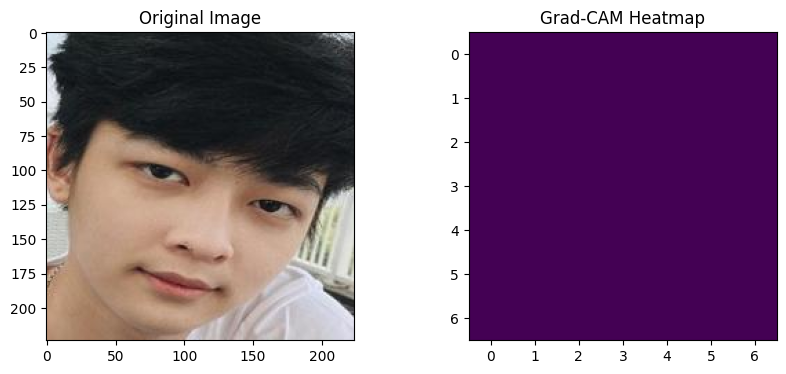

🔍 Uji Demo: Kaukasoid-Indic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
📌 Prediksi: Melanesoid (Probabilitas: 0.6425)


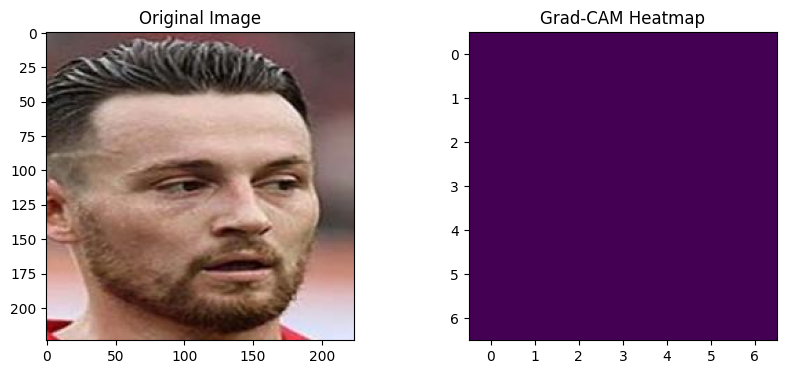

🔍 Uji Demo: Malayan Mongoloid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
📌 Prediksi: Melanesoid (Probabilitas: 0.6407)


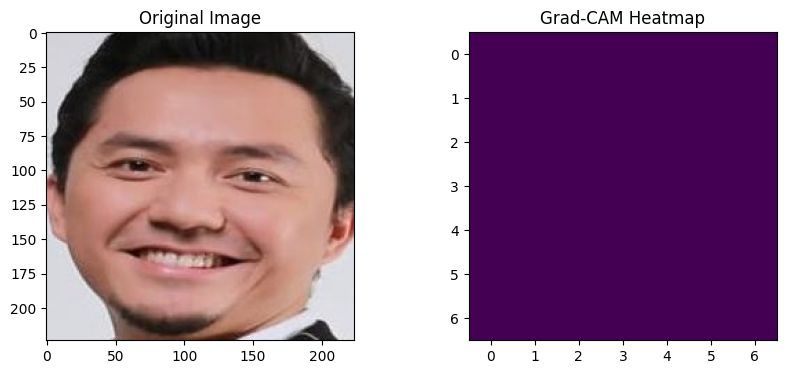

🔍 Uji Demo: Melanesoid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
📌 Prediksi: Melanesoid (Probabilitas: 0.6423)


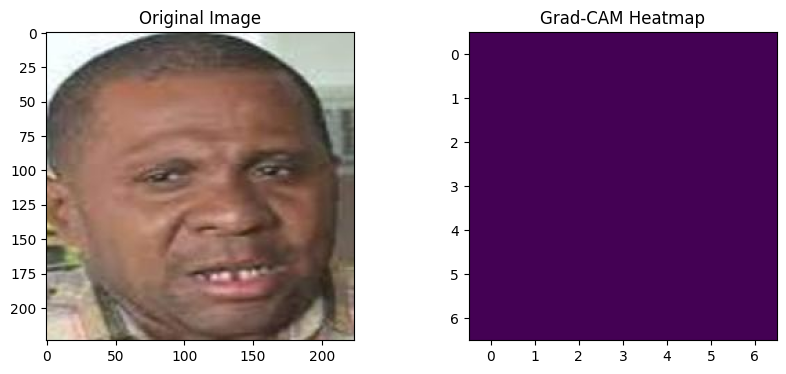

In [48]:
demo_images = {
    "Asiatic Mongoloid": r"D:\Penelitian\Split_TAHAP2\val\Asian_Mongoloid\58ba5aeef5400e19df4ac401253bd5ff.jpg",
    "Kaukasoid-Indic": r"D:\Penelitian\Split_TAHAP2\val\Kaukasoid-Indic\766-marc klok.jpg",
    "Malayan Mongoloid": r"D:\Penelitian\Split_TAHAP2\val\Malayan_Mongoloid\IMG_3893.jpeg",
    "Melanesoid": r"D:\Penelitian\Split_TAHAP2\val\Melanesoid\images (28).jpeg",
}


# Tes
for label, path in demo_images.items():
    print(f"🔍 Uji Demo: {label}")
    prediksi_dan_gradcam(path, override=True)


In [ ]:
# Misalnya dari user input saat sidang
img_path = "data_uji_tunggal.jpg"
hasil = prediksi_dan_gradcam(img_path, override=True)
print(f"Hasil akhir: {hasil}")
